<a href="https://colab.research.google.com/github/dolmani38/Summary2/blob/main/ko_multi-discriminator%20GAN%201004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Korean Multi-Discriminator GAN


ABSTRACT

----


#4. Implementation


## 4.1 기본 설정...

In [1]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!pip install keybert
!pip3 install transformers
!pip3 install sentence-transformers

#!pip install sentence-transformers

     |████████████████████████████████| 2.9 MB 9.3 MB/s 
     |████████████████████████████████| 895 kB 49.9 MB/s 
     |████████████████████████████████| 636 kB 69.4 MB/s 
     |████████████████████████████████| 52 kB 2.2 MB/s 
     |████████████████████████████████| 3.3 MB 68.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 85 kB 3.6 MB/s 
     |████████████████████████████████| 1.2 MB 67.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-py3-none-any.whl size=126710 sha256=022a2f47b4cebeacf9dd62ef03e2c60cc80acbfda65788ffb01fca02282bd61c
  Stored in directory: /root/.cache/pip/wheels/d1/c1/0f/faafd427f705c4b012274ba60d9a91d75830306811e1355293
Successfully built sentence-transformers


In [3]:
import matplotlib.pyplot as plt
# set seeds for reproducability
from numpy.random import seed
#seed(1)

import pandas as pd
import numpy as np
import string, os 

import urllib.request
import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

logout = True

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [5]:
# Print iterations progress
class ProgressBar:

    def __init__(self,total=20, prefix = '', suffix = '', decimals = 1, length = 20, fill = '|', printEnd = "\r"):
        self.total = total
        self.prefix = prefix
        self.suffix = suffix
        self.decimals = decimals
        self.length = length
        self.fill = fill
        self.printEnd = printEnd
        self.ite = 0
        self.back_filledLength = 0

    def printProgress(self,iteration, text):
        self.ite += iteration
        percent = ("{0:." + str(self.decimals) + "f}").format(100 * (self.ite / float(self.total)))
        filledLength = int(self.length * self.ite // self.total)
        bar = self.fill * filledLength + '.' * (self.length - filledLength)
        if filledLength > self.back_filledLength or percent == 100:
            if logout:
                print(f'\r{self.prefix} |{bar}| {percent}% {self.suffix}  {text}', end="", flush=True)
            # Print New Line on Complete
            if self.ite == self.total: 
                if logout:
                    print()
        self.back_filledLength = filledLength    

In [6]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

##4.2 Grammar Discriminator Class

In [7]:
from transformers import BertTokenizer, BertTokenizerFast,AutoTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split

import time
import random
import datetime
import pickle

# 간단한 전처리
def clean_text(txt):
    txt = txt.replace('\n',' ')
    txt = txt.replace('\r',' ')    
    txt = txt.replace('=','')
    txt = txt.replace('\"','')   
    txt = txt.replace('\'','')
    #txt = txt.replace(',','')
    txt = txt.replace('..','')
    txt = txt.replace('...','')
    txt = txt.replace(' .','.')
    txt = txt.replace('.','. ')
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')           
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')             
    return txt.strip()

def shuffling(txt):
    txt_list = txt.split(' ')
    random.shuffle(txt_list)
    return ' '.join(txt_list)

def collect_training_dataset_for_grammar_discriminator(sentences_dataset):

    sentences = []
    labels = []

    for txtss in sentences_dataset:
        txtss = clean_text(txtss)
        txts = txtss.strip().split('.')
        for txt in txts:  
            txt = txt.strip()
            if len(txt) > 10:
                #ko_grammar_dataset.append([txt,1])
                txt = txt.replace('.','')
                tf = random.choice([True,False])
                # 정상 또는 비정상 둘중에 하나만 데이터셋에 추가
                if (tf):
                    sentences.append(txt) # '.'의 위치를 보고 True, False를 판단 하기 땜에...
                    labels.append(1)
                else:
                    sentences.append(shuffling(txt))
                    labels.append(0)

    return sentences,labels

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

class Grammar_Discriminator:


    def __init__(self, pretraoned_kobert_model_name='bert-base-v2', input_dir=None):

        if input_dir is None:
            self.tokenizer = BertTokenizerFast.from_pretrained(pretraoned_kobert_model_name)
            self.discriminator = BertForSequenceClassification.from_pretrained(
                                    pretraoned_kobert_model_name, # Use the 12-layer BERT model, with an uncased vocab.
                                    num_labels = 2, # The number of output labels--2 for binary classification.
                                                    # You can increase this for multi-class tasks.   
                                    output_attentions = False, # Whether the model returns attentions weights.
                                    output_hidden_states = False, # Whether the model returns all hidden-states.
                                )            
        else:
            self.__load_model(input_dir)




    def set_dataset(self, sentences,labels):
        # Print the original sentence.
        print(' Original: ', sentences[0])

        # Tokenize all of the sentences and map the tokens to thier word IDs.
        input_ids = []
        attention_masks = []

        # For every sentence...
        for i, sent in enumerate(sentences):
            print(f'\r Tokenize {i+1}/{len(sentences)}', end="", flush=True)            
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = self.tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 64,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation = True,
                        )
            
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])
            
            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])

        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        labels = torch.tensor(labels)

        # Print sentence 0, now as a list of IDs.
        print('Original: ', sentences[0])
        print('Token IDs:', input_ids[0])

        # Training & Validation Split
        # Divide up our training set to use 90% for training and 10% for validation.

        # Combine the training inputs into a TensorDataset.
        dataset = TensorDataset(input_ids, attention_masks, labels)

        # Create a 90-10 train-validation split.

        # Calculate the number of samples to include in each set.
        train_size = int(0.9 * len(dataset))
        val_size = len(dataset) - train_size

        # Divide the dataset by randomly selecting samples.
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        print('{:>5,} training samples'.format(train_size))
        print('{:>5,} validation samples'.format(val_size))

        # The DataLoader needs to know our batch size for training, so we specify it 
        # here. For fine-tuning BERT on a specific task, the authors recommend a batch 
        # size of 16 or 32.
        self.batch_size = 32

        # Create the DataLoaders for our training and validation sets.
        # We'll take training samples in random order. 
        self.train_dataloader = DataLoader(
                    train_dataset,  # The training samples.
                    sampler = RandomSampler(train_dataset), # Select batches randomly
                    batch_size = self.batch_size # Trains with this batch size.
                )

        # For validation the order doesn't matter, so we'll just read them sequentially.
        self.validation_dataloader = DataLoader(
                    val_dataset, # The validation samples.
                    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                    batch_size = self.batch_size # Evaluate with this batch size.
                )        


    def train(self,epochs=4):
        # Tell pytorch to run this model on the GPU.
        self.discriminator.cuda()

        # Get all of the model's parameters as a list of tuples.
        params = list(self.discriminator.named_parameters())

        print('The BERT model has {:} different named parameters.\n'.format(len(params)))

        print('==== Embedding Layer ====\n')

        for p in params[0:5]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

        print('\n==== First Transformer ====\n')

        for p in params[5:21]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

        print('\n==== Output Layer ====\n')

        for p in params[-4:]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))  

        # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
        # I believe the 'W' stands for 'Weight Decay fix"
        self.optimizer = AdamW(self.discriminator.parameters(),
                        lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                        )

        # Number of training epochs. The BERT authors recommend between 2 and 4. 
        # We chose to run for 4, but we'll see later that this may be over-fitting the
        # training data.
        #epochs = 2

        # Total number of training steps is [number of batches] x [number of epochs]. 
        # (Note that this is not the same as the number of training samples).
        total_steps = len(self.train_dataloader) * epochs

        # Create the learning rate scheduler.
        scheduler = get_linear_schedule_with_warmup(self.optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)
            
        # This training code is based on the `run_glue.py` script here:
        # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

        # Set the seed value all over the place to make this reproducible.
        seed_val = 42

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)

        # We'll store a number of quantities such as training and validation loss, 
        # validation accuracy, and timings.
        training_stats = []

        # Measure the total training time for the whole run.
        total_t0 = time.time()

        # For each epoch...
        for epoch_i in range(0, epochs):
            
            # ========================================
            #               Training
            # ========================================
            
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            print('Training...')

            # Measure how long the training epoch takes.
            t0 = time.time()

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode. Don't be mislead--the call to 
            # `train` just changes the *mode*, it doesn't *perform* the training.
            # `dropout` and `batchnorm` layers behave differently during training
            # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
            self.discriminator.train()

            # For each batch of training data...
            for step, batch in enumerate(self.train_dataloader):

                # Progress update every 40 batches.
                if step % 40 == 0 and not step == 0:
                    # Calculate elapsed time in minutes.
                    elapsed = format_time(time.time() - t0)
                    
                    # Report progress.
                    print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(self.train_dataloader), elapsed))

                # Unpack this training batch from our dataloader. 
                #
                # As we unpack the batch, we'll also copy each tensor to the GPU using the 
                # `to` method.
                #
                # `batch` contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)

                # Always clear any previously calculated gradients before performing a
                # backward pass. PyTorch doesn't do this automatically because 
                # accumulating the gradients is "convenient while training RNNs". 
                # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
                self.discriminator.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # It returns different numbers of parameters depending on what arguments
                # arge given and what flags are set. For our useage here, it returns
                # the loss (because we provided labels) and the "logits"--the model
                # outputs prior to activation.
                outputs = self.discriminator(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask, 
                                    labels=b_labels)
                loss, logits = outputs.loss, outputs.logits
                # Accumulate the training loss over all of the batches so that we can
                # calculate the average loss at the end. `loss` is a Tensor containing a
                # single value; the `.item()` function just returns the Python value 
                # from the tensor.
                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Clip the norm of the gradients to 1.0.
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), 1.0)

                # Update parameters and take a step using the computed gradient.
                # The optimizer dictates the "update rule"--how the parameters are
                # modified based on their gradients, the learning rate, etc.
                self.optimizer.step()

                # Update the learning rate.
                scheduler.step()

            # Calculate the average loss over all of the batches.
            avg_train_loss = total_train_loss / len(self.train_dataloader)            
            
            # Measure how long this epoch took.
            training_time = format_time(time.time() - t0)

            print("")
            print("  Average training loss: {0:.2f}".format(avg_train_loss))
            print("  Training epcoh took: {:}".format(training_time))
                
            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure our performance on
            # our validation set.

            print("")
            print("Running Validation...")

            t0 = time.time()

            # Put the model in evaluation mode--the dropout layers behave differently
            # during evaluation.
            self.discriminator.eval()

            # Tracking variables 
            total_eval_accuracy = 0
            total_eval_loss = 0
            nb_eval_steps = 0

            # Evaluate data for one epoch
            for batch in self.validation_dataloader:
                
                # Unpack this training batch from our dataloader. 
                #
                # As we unpack the batch, we'll also copy each tensor to the GPU using 
                # the `to` method.
                #
                # `batch` contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)
                
                # Tell pytorch not to bother with constructing the compute graph during
                # the forward pass, since this is only needed for backprop (training).
                with torch.no_grad():        

                    # Forward pass, calculate logit predictions.
                    # token_type_ids is the same as the "segment ids", which 
                    # differentiates sentence 1 and 2 in 2-sentence tasks.
                    # The documentation for this `model` function is here: 
                    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                    # Get the "logits" output by the model. The "logits" are the output
                    # values prior to applying an activation function like the softmax.
                    outputs = self.discriminator(b_input_ids, 
                                        token_type_ids=None, 
                                        attention_mask=b_input_mask,
                                        labels=b_labels)
                loss, logits = outputs.loss, outputs.logits
                # Accumulate the validation loss.
                total_eval_loss += loss.item()

                # Move logits and labels to CPU
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()

                # Calculate the accuracy for this batch of test sentences, and
                # accumulate it over all batches.
                total_eval_accuracy += flat_accuracy(logits, label_ids)
                

            # Report the final accuracy for this validation run.
            avg_val_accuracy = total_eval_accuracy / len(self.validation_dataloader)
            print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

            # Calculate the average loss over all of the batches.
            avg_val_loss = total_eval_loss / len(self.validation_dataloader)
            
            # Measure how long the validation run took.
            validation_time = format_time(time.time() - t0)
            
            print("  Validation Loss: {0:.2f}".format(avg_val_loss))
            print("  Validation took: {:}".format(validation_time))

            # Record all statistics from this epoch.
            training_stats.append(
                {
                    'epoch': epoch_i + 1,
                    'Training Loss': avg_train_loss,
                    'Valid. Loss': avg_val_loss,
                    'Valid. Accur.': avg_val_accuracy,
                    'Training Time': training_time,
                    'Validation Time': validation_time
                }
            )

        print("")
        print("Training complete!")

        print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
            

        return training_stats

    def save_model(self, output_dir = './model_save/'):
        # Create output directory if needed
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        print("Saving model to %s" % output_dir)

        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = self.discriminator.module if hasattr(self.discriminator, 'module') else self.discriminator  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)

        # Good practice: save your training arguments together with the trained model
        # torch.save(args, os.path.join(output_dir, 'training_args.bin'))

    def __load_model(self, input_dir = './drive/MyDrive/Colab Notebooks/summary/en_grammar_check_model'):
        print('Loading BERT tokenizer...')
        self.tokenizer = BertTokenizerFast.from_pretrained(input_dir)
        self.discriminator = BertForSequenceClassification.from_pretrained(input_dir)

    def transfer_learning(self, sentences, train_for = True):
        
        input_ids = []
        attention_masks = []

        # For every sentence...
        for sent in sentences:
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = self.tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 64,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation = True,
                        )
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])

            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])
        
        if train_for:
            b_labels = torch.ones(len(sentences),dtype=torch.long).to(device)
        else:
            b_labels = torch.zeros(len(sentences),dtype=torch.long).to(device)
        #print(b_labels)
        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0).to(device)
        attention_masks = torch.cat(attention_masks, dim=0).to(device)    
        #if str(discriminator1.device) == 'cpu':
        #    pass
        #else:
        #    input_ids = input_ids.to(device)
        #    attention_masks = attention_masks.to(device)        

        outputs = self.discriminator(input_ids, 
                            token_type_ids=None, 
                            attention_mask=attention_masks, 
                                labels=b_labels)

        #print(outputs)
        #return torch.sigmoid(outputs[0][:,1])
        #return outputs[0][:,1]
        return outputs['loss'], outputs['logits']


# 문법 discriminator 활용

In [8]:
g_discriminator = Grammar_Discriminator(input_dir = '/content/drive/MyDrive/Colab Notebooks/summary/ko_grammar_model4')

Loading BERT tokenizer...


In [9]:
txt = ['최근 날씨가 포근해지면서 산을 찾는 사람들도 늘고 있는데요','서비스를 음원 플랫폼 스포티파이가 국내 론칭한다']
g_discriminator.discriminator.to(device)
g_discriminator.transfer_learning(txt)

(tensor(4.3705, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor([[-4.8017,  5.1989],
         [ 4.3898, -4.3509]], device='cuda:0', grad_fn=<AddmmBackward>))

##4.3 Static similarity discriminator class

In [10]:
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
import scipy


class Similarity_Discriminator:
    '''
    _instance = None
    _embedder = None
    def __new__(cls,pre_trained_model_name='stsb-roberta-large'):
        if cls._instance is None:
            print('Creating Similarity_Discriminator object')
            cls._instance = super(Similarity_Discriminator, cls).__new__(cls)
            # Put any initialization here.
            cls._embedder = SentenceTransformer(pre_trained_model_name)
        return cls._instance

    '''

    def __init__(self,pre_trained_model_name='stsb-roberta-large'): #'roberta-large-nli-stsb-mean-tokens'):
        print('Creating Similarity_Discriminator object')
        # Put any initialization here.
        self._embedder = SentenceTransformer(pre_trained_model_name,device=device)  
        #self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)

    def encode(self,texts):
        return self._embedder.encode(texts,show_progress_bar=False)

    def similarity(self, query_text, org_text_emb):
        queries = nltk.sent_tokenize(query_text)
        query_embeddings = self._embedder.encode(queries,show_progress_bar=False)
        #query_embeddings = self._embedder.encode(queries,show_progress_bar=False)
        #print(queries)
        #print(org_text_emb)
        
        if len(query_embeddings) == 0:
            return 0.0

        cos_scores = scipy.spatial.distance.cdist(query_embeddings, org_text_emb, "cosine")
        similarity_score = 1.0 - np.mean(np.min(cos_scores,axis=1))
        '''
        for query, query_embedding in zip(queries, query_embeddings):
            distances = scipy.spatial.distance.cdist([query_embedding], [org_text_emb], "cosine")[0]
            results = zip(range(len(distances)), distances)
            for idx, distance in results:
                scores.append(1-distance)
        '''
        return similarity_score  
 

###4.3.1 한국어 문장 유사도 pre-trained model 적용

In [11]:
#del s_discriminator

s_discriminator = Similarity_Discriminator(pre_trained_model_name='roberta-large-nli-stsb-mean-tokens')
#s_discriminator = Similarity_Discriminator()

Creating Similarity_Discriminator object


Downloading:   0%|          | 0.00/748 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.00k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/191 [00:00<?, ?B/s]

# ExtactiveSummarizer

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from nltk.tokenize import sent_tokenize
import numpy as np
import networkx as nx
import re
import torch
from torch import nn
from transformers import BertTokenizer, BertModel

In [79]:

class ExtactiveSummarizer:
    # 한국어의 경우, 'kykim/bert-kor-base'
    def __init__(self,model_name='bert-base-uncased'):

        #nltk.download('stopwords')
        nltk.download('punkt')

        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name, return_dict=True, output_attentions=True)
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)

        # If there's a GPU available...
        if torch.cuda.is_available():    
            # Tell PyTorch to use the GPU.    
            self.device = torch.device("cuda")
        # If not...
        else:
            self.device = torch.device("cpu")

        self.model.to(self.device)
        self.cos.to(self.device)
        
    def read_article(self,text):        
        sentences =[]        
        sentences = sent_tokenize(text)    
        for sentence in sentences:        
            sentence.replace("[^a-zA-Z0-9]"," ")     
        return sentences

    def sentence_similarity(self,sent1,sent2):
        tok_sent1 = self.tokenizer(sent1, return_tensors="pt")
        tok_sent2 = self.tokenizer(sent2, return_tensors="pt")
        tok_sent1.to(self.device)
        tok_sent2.to(self.device)
        outputs = self.model(**tok_sent1)
        sent_1_pooler_output = outputs.pooler_output

        outputs = self.model(**tok_sent2)
        sent_2_pooler_output = outputs.pooler_output
        return self.cos(sent_1_pooler_output, sent_2_pooler_output).cpu().detach().numpy()

    def get_self_attention_weight(self,sentence):
        tok_sent = self.tokenizer(sentence, return_tensors="pt")
        tok_sent.to(self.device)
        outputs = self.model(**tok_sent)
        
        attentions = torch.stack(outputs.attentions)
        #attention = outputs[-1]  # Output includes attention weights when output_attentions=True
        last_attentions = attentions[11][0][11]
        #print(last_attentions.shape)
        tokens = [self.tokenizer.convert_ids_to_tokens(s) for s in tok_sent['input_ids'].tolist()[0]]
        #print(tokens)
        attention_map = []
        for i,token in enumerate(tokens):
            if token.startswith('##'):
                (ii,tt,s) = attention_map[-1]
                tt += token.replace('##','')
                s0 = torch.sum(last_attentions[:,i]).item()
                s1 = s if s > s0 else s0
                attention_map[len(attention_map)-1] = (ii,tt,s1)
            else:
                attention_map.append((i,token,torch.sum(last_attentions[:,i]).item()))
        return attention_map

    # Create similarity matrix among all sentences
    def build_similarity_matrix(self,sentences):
        #create an empty similarity matrix
        similarity_matrix = np.zeros((len(sentences),len(sentences)))
        
        for idx1 in range(len(sentences)):
            for idx2 in range(len(sentences)):
                if idx1!=idx2:
                    similarity_matrix[idx1][idx2] = self.sentence_similarity(sentences[idx1],sentences[idx2])
                    
        return similarity_matrix

    # Generate and return text summary
    def generate_summary(self,text,top_n,min_length=30):
        
        ft = []
        org_sentences = np.array(nltk.sent_tokenize(text))
        for txt in org_sentences:
            if len(txt) > min_length:
                ft.append(txt)
        text = ' '.join(ft)

        #stop_words = stopwords.words('english')
        summarize_text = []
        
        # Step1: read text and tokenize
        sentences = self.read_article(text)
        
        # Steo2: generate similarity matrix across sentences
        sentence_similarity_matrix = self.build_similarity_matrix(sentences)
        
        # Step3: Rank sentences in similarirty matrix
        sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_matrix)
        scores = nx.pagerank(sentence_similarity_graph)
        '''
        #Step4: sort the rank and place top sentences
        ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)),reverse=True)
        
        #print(ranked_sentences)
        # Step 5: get the top n number of sentences based on rank    
        for i in range(top_n if top_n < len(ranked_sentences) else len(ranked_sentences)):
            summarize_text.append(ranked_sentences[i][1])
        '''
        orderd = [(o,s) for o,s in enumerate(scores)]
        orderd.sort(key=lambda e: e[1],reverse=True)
        top_n = top_n if len(orderd) > top_n else len(orderd)
        a = [orderd[i][0] for i in range(0,top_n)]
        a.sort()
        summ_text = " ".join([sentences[i] for i in a])
        
        # Step 6 : outpur the summarized version
        return summ_text,len(sentences)   # " ".join(summarize_text), len(sentences)  #

In [64]:
del es
es = ExtactiveSummarizer(model_name='kykim/bert-kor-base')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
es.sentence_similarity('검사 건수가 줄어드는 주말이지만, 전날 3273명에 이어 역대 두 번째로 높은 수치를 기록했습니다.','검사 줄어드는 주말이지만, 전날 3273명에 이어 건수가 역대 두 번째로 높은 수치를 기록했습니다.')

array([0.96269804], dtype=float32)

In [16]:
es.get_self_attention_weight('검사 건수가 줄어드는 주말이지만, 전날 3273명에 이어 역대 두 번째로 높은 수치를 기록했습니다.')

[(0, '[CLS]', 0.898577868938446),
 (1, '검사', 0.5013380646705627),
 (2, '건', 0.5563266277313232),
 (3, '##수가', 0.8456023335456848),
 (4, '줄어드는', 0.8770961761474609),
 (5, '주말', 0.6293195486068726),
 (6, '##이지만', 1.2746742963790894),
 (7, ',', 0.7676283717155457),
 (8, '전날', 0.22542327642440796),
 (9, '32', 0.03144492208957672),
 (10, '##73', 0.6037900447845459),
 (11, '##명에', 0.2867104411125183),
 (12, '이어', 1.0958592891693115),
 (13, '역대', 1.2786242961883545),
 (14, '두', 0.5708819627761841),
 (15, '번째로', 2.155564785003662),
 (16, '높은', 0.6527972221374512),
 (17, '수치를', 0.4519978165626526),
 (18, '기록', 0.7711131572723389),
 (19, '##했습니다', 0.9891842603683472),
 (20, '.', 5.295561790466309),
 (21, '[SEP]', 1.2404837608337402)]

# 4.4 Document source class

## 한국어 Sample data 수집

In [17]:
import json  
import zipfile  

if False:
    data_1 = None  
    data = None  
    with zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/summary/data/사설잡지_2.train_original.json.zip", "r") as z:
        with z.open('train_original.json') as f:  
            data = f.read()  
            data_1 = json.loads(data.decode("utf-8"))

In [18]:
if False:
    data_2 = None  
    data = None  
    with zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/summary/data/신문기사_2.train_original.json.zip", "r") as z:
        with z.open('train_original.json') as f:  
            data = f.read()  
            data_2 = json.loads(data.decode("utf-8"))

In [19]:
if False:
    random.shuffle(data_1)
    random.shuffle(data_2)

In [20]:
if False:
    sentences_dataset = []
    gold_summary = []
    for i in range(len(data_2)):
        sentences_dataset.append(' '.join(data_2[i]['article_original']))
        gold_summary.append(data_2[i]['abstractive'])

    for i in range(len(data_1)):
        sentences_dataset.append(' '.join(data_1[i]['article_original']))
        gold_summary.append(data_1[i]['abstractive'])

In [21]:
import pickle
if False:
    with open("/content/drive/MyDrive/Colab Notebooks/summary/data/ko_ai_hub_sample.bin", "wb") as fp:
        pickle.dump([sentences_dataset,gold_summary],fp)

In [22]:
import pickle
if True:
    with open("/content/drive/MyDrive/Colab Notebooks/summary/data/ko_ai_hub_sample.bin", "rb") as fp:
        dt = pickle.load(fp)
    sentences_dataset = dt[0]
    gold_summary = dt[1]

## 4.4.2 source class 구현

In [23]:
# 간단한 전처리
def __clean_text(txt):
    txt = txt.replace('\n',' ')
    txt = txt.replace('\r',' ')    
    #txt = txt.replace('=','')
    #txt = txt.replace('\"','')   
    #txt = txt.replace('\'','')
    #txt = txt.replace(',','')
    #txt = txt.replace('..','')
    #txt = txt.replace('...','')
    txt = txt.replace('.',' ')
    #txt = txt.replace('.','. ')
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')           
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')             
    return txt.strip()

def get_prepared_doc(txt):
    docs = []
    sentences = np.array(nltk.sent_tokenize(txt))
    for sen in sentences:
        docs.append(__clean_text(sen) +'.')
    return (' '.join(docs)).strip()

In [24]:

combine_matching_table = {}
combine_matching_table['다.'] = '고'
conjunction_table = ['그러던','그래서','그러나','그런데','그리고','그랬더니','그러니까','하지만','그래서']


In [25]:
def combine_sentence(txt):
    for c in combine_matching_table.keys():
        if txt.endswith(c):
            txt = txt.replace(c,combine_matching_table[c])
    return txt

In [67]:


class Source:

    def __init__(self,full_text,org_text,delete_ending = False,attendtion_rate=0.3):
        self.full_text = full_text
        self.org_text = org_text
        self.delete_ending = delete_ending
        self.attendtion_rate = attendtion_rate

    def __crean_text(self, txt):
        txt = txt.replace('\n',' ')
        txt = txt.replace('\r',' ')    
        txt = txt.replace('=','')
        txt = txt.replace('\"','')   
        txt = txt.replace('\'','')
        txt = txt.replace(',','')
        txt = txt.replace('..','')
        txt = txt.replace('...','')
        txt = txt.replace(' .','.')
        txt = txt.replace('.','. ')
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        return txt.strip()

    def set_key_rate(self,s_discriminator):
        # full_text에 대한 처리...
        self.full_text = self.__crean_text(self.full_text.strip())
        self.full_sentences = np.array(nltk.sent_tokenize(self.full_text))
        self.s_discriminator = s_discriminator
        self.full_text_emb = self.s_discriminator.encode(self.full_sentences)   

        # original sentance, 즉 source sentence에 대한 처리
        self.org_text = self.__crean_text(self.org_text.strip())
        if logout:
            print('-'*50)
            print(self.org_text)
            print('-'*50)  

        # 두장 이상의 문장이 있는 경우, '그리고' 등의 연결문을 삭제 한다.
        # 그래야 grammar dicsriminator의 성능이 나온다.
        self.org_sentences = np.array(nltk.sent_tokenize(self.org_text))
        self.org_text_emb = self.s_discriminator.encode(self.org_sentences)
        for i,sents in enumerate(self.org_sentences):
            for cj in conjunction_table: 
                if sents.startswith(cj):
                    self.org_sentences[i] = sents[len(cj):].strip()

        #print(s)
        #print(self.org_sentences)
        # 하나의 문장을 token 단위로 잘라서 {index:token} dict을 만든다.
        # 또한, 각 token의 attention을 설정한다.
        self.org_term_set = (' '.join(self.org_sentences)).strip().split(' ')
        self.org_source_length = len(self.org_term_set)
        self.term_table = {}

        self.seps = []
        self.bias_table = {}
        #morp_table = {}
        aw = 0.0
        attentions = []
        self_attentions = es.get_self_attention_weight(self.org_text)
        #print(self_attentions)
        self_attentions_max = 0
        self_attentions_map = {}
        for index, word in enumerate(self.org_term_set):
            self.term_table[index] = word
            #attention = cosine_similarity(self.full_text,word)
            #attentions.append(attention)
            sa = 0
            for u in range(index,len(self_attentions)):
                if word.lower().replace('.','') == self_attentions[u][1]:
                    sa = self_attentions[u][2]
                    if sa > self_attentions_max:
                        self_attentions_max = sa

            self_attentions_map[index] = sa
            #print(f'{word} \t\t {attention:.4f} {sa:.4f}')
            
        #print('self_attentions_max',self_attentions_max)
        attentions = list(self_attentions_map.values())
        attentions.sort(reverse=True)
        #문장 전체 token의 30%에 attention을 준다.
        trs = attentions[int(len(attentions)*self.attendtion_rate + 0.5)]

        for index, word in enumerate(self.org_term_set):
            self.term_table[index] = word
            self.bias_table[index] = self_attentions_map[index] - trs #self_attentions_max
            #attention = self_attentions_map[index] #cosine_similarity(self.full_text,word)
            self.bias_table[index] = (0.0 if self.bias_table[index] > 0 else -1.0)
            #self.bias_table[index] = (self.bias_table[index] if self.bias_table[index] > 0 else -1.0)
            if len(self.org_term_set) - 1 == index:
                    self.bias_table[index] = 0.1
            '''
            if attention >= trs or index == len(self.org_term_set)-1:
                self.bias_table[index] = self_attentions_map[index] - trs #0.0 #attention
            else:
                self.bias_table[index] = -1.0 #attention #-cosine_similarity(self.full_text,word)
            '''
            
            if word.endswith(('.','?')):
                self.seps.append(index)
                if self.org_source_length - 1 == index:
                    pass
                else:
                    self.term_table[index] = combine_sentence(word)
        #print(self.term_table)
        #print(list(self.bias_table.values()))
        # 또 다른 token 단위의 {index:token} dict을 만드는데, 이는 generator의 조합이
        # 문법적으로 부실할 경우, corrector가 보정할때 '~~고'의 중간 연결문을 
        # 부드럽게 만들기 위해 중간 문장의 '~다.'를 삭제한 dict에 해당한다.
        self.combination_table = {}
        for index, word in enumerate(self.org_term_set):
            self.combination_table[index] = word
            if index < len(self.org_term_set)-1: #중간 문장의 '~다.'를 삭제한다.
                if self.org_term_set[index].endswith('다.'):
                    self.combination_table[index] = word[0:len(word)-2]
        if logout:
            print('Length ------------------------------------|',len(self.term_table))
            print(self.bias_table)
        #print(self.combination_table)
        if len(self.term_table) > 128:
            raise Exception("Too much sentence length.")

    def get_org_sample(self, num):
        return self.org_sentences[np.random.choice(len(self.org_sentences), num)]

    def get_source_embedded_code(self):
        return self.org_text_emb

    def get_random_text(self,rate=0.5):
        cnt = int(len(self.term_table) * rate)
        a = list(self.term_table.keys())
        b = np.random.choice(a, cnt)
        c = [fruit for fruit in a if fruit not in b]
        txt = []
        for i in c:
            txt.append(self.term_table[i])
        return ' '.join(txt).strip(), hash(tuple(b))

## N-Gram Similarity Comparison

https://gist.github.com/gaulinmp/da5825de975ed0ea6a24186434c24fe4

In [27]:
# Get Tuple algorithms 
import re
import math
import numpy as np
from itertools import chain
from collections import Counter
import nltk
from nltk.util import ngrams # This is the ngram magic.
from textblob import TextBlob

NGRAM = 4

re_sent_ends_naive = re.compile(r'[.\n]')
re_stripper_alpha = re.compile('[^a-zA-Z]+')
re_stripper_naive = re.compile('[^a-zA-Z\.\n]')

splitter_naive = lambda x: re_sent_ends_naive.split(re_stripper_naive.sub(' ', x))

sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

def get_tuples_nosentences(txt):
    """Get tuples that ignores all punctuation (including sentences)."""
    if not txt: return None
    #ng = ngrams(re_stripper_alpha.sub(' ', txt).split(), NGRAM)
    ng = ngrams(txt, NGRAM)
    return list(ng)

def get_tuples_manual_sentences(txt):
    """Naive get tuples that uses periods or newlines to denote sentences."""
    if not txt: return None
    sentences = (x.split() for x in splitter_naive(txt) if x)
    ng = (ngrams(x, NGRAM) for x in sentences if len(x) >= NGRAM)
    return list(chain(*ng))

def get_tuples_nltk_punkt_sentences(txt):
    """Get tuples that doesn't use textblob."""
    if not txt: return None
    sentences = (re_stripper_alpha.split(x) for x in sent_detector.tokenize(txt) if x)
    # Need to filter X because of empty 'words' from punctuation split
    ng = (ngrams(filter(None, x), NGRAM) for x in sentences if len(x) >= NGRAM)
    return list(chain(*ng))

def get_tuples_textblob_sentences(txt):
    """New get_tuples that does use textblob."""
    if not txt: return None
    tb = TextBlob(txt)
    ng = (ngrams(x.words, NGRAM) for x in tb.sentences if len(x.words) > NGRAM)
    return [item for sublist in ng for item in sublist]

def jaccard_distance(a, b):
    """Calculate the jaccard distance between sets A and B"""
    a = set(a)
    b = set(b)
    return 1.0 * len(a&b)/len(a|b)

def cosine_similarity_ngrams(a, b):
    vec1 = Counter(a)
    vec2 = Counter(b)
    
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    return float(numerator) / denominator


def test():
    paragraph = """It was the best of times, it was the worst of times.
               It was the age of wisdom? It was the age of foolishness!
               I first met Dr. Frankenstein in Munich; his monster was, presumably, at home."""
    print(paragraph)
    _ = get_tuples_nosentences(paragraph);print("Number of N-grams (no sentences):", len(_));_

    _ = get_tuples_manual_sentences(paragraph);print("Number of N-grams (naive sentences):", len(_));_

    _ = get_tuples_nltk_punkt_sentences(paragraph);print("Number of N-grams (nltk sentences):", len(_));_

    _ = get_tuples_textblob_sentences(paragraph);print("Number of N-grams (TextBlob sentences):", len(_));_

    a = get_tuples_nosentences("It was the best of times.")
    b = get_tuples_nosentences("It was the worst of times.")
    print("Jaccard: {}   Cosine: {}".format(jaccard_distance(a,b), cosine_similarity_ngrams(a,b)))

    a = get_tuples_nosentences("Above is a bad example of four-gram similarity.")
    b = get_tuples_nosentences("This is a better example of four-gram similarity.")
    print("Jaccard: {}   Cosine: {}".format(jaccard_distance(a,b), cosine_similarity_ngrams(a,b)))

    a = get_tuples_nosentences("Jaccard Index ignores repetition repetition repetition repetition repetition.")
    b = get_tuples_nosentences("Cosine similarity weighs repetition repetition repetition repetition repetition.")
    print("Jaccard: {}   Cosine: {}".format(jaccard_distance(a,b), cosine_similarity_ngrams(a,b)))
test()

It was the best of times, it was the worst of times.
               It was the age of wisdom? It was the age of foolishness!
               I first met Dr. Frankenstein in Munich; his monster was, presumably, at home.
Number of N-grams (no sentences): 214
Number of N-grams (naive sentences): 25
Number of N-grams (nltk sentences): 25
Number of N-grams (TextBlob sentences): 25
Jaccard: 0.6071428571428571   Cosine: 0.755742181606458
Jaccard: 0.6071428571428571   Cosine: 0.755742181606458
Jaccard: 0.23214285714285715   Cosine: 0.9208243668497166


In [28]:
def cosine_similarity(src_txt,trg_txt):
    try:
        if src_txt == None or src_txt.strip() == '':
            return 0.0
        if trg_txt == None or trg_txt.strip() == '':
            return 0.0

        a = get_tuples_nosentences(src_txt)
        b = get_tuples_nosentences(trg_txt)
        return cosine_similarity_ngrams(a,b)
    except Exception as ex:
        #print(src_txt,trg_txt)
        return 0.0

In [29]:
txt = """
The judge agreed with police that he would have been over the limit at the time his red Citroen hit Miss Titley’s blue Daihatsu Cuore on a road near Yarmouth, Isle of Wight, on October 11, 2013.
His phone records showed he was also texting around the time of the crash.
"""
s = Source(txt,txt)
s.set_key_rate(s_discriminator)


--------------------------------------------------
The judge agreed with police that he would have been over the limit at the time his red Citroen hit Miss Titley’s blue Daihatsu Cuore on a road near Yarmouth Isle of Wight on October 11 2013. His phone records showed he was also texting around the time of the crash.
--------------------------------------------------
Length ------------------------------------| 51
{0: -1.0, 1: -1.0, 2: -1.0, 3: 0.0, 4: -1.0, 5: 0.0, 6: -1.0, 7: -1.0, 8: -1.0, 9: -1.0, 10: 0.0, 11: -1.0, 12: -1.0, 13: 0.0, 14: -1.0, 15: 0.0, 16: -1.0, 17: 0.0, 18: -1.0, 19: -1.0, 20: -1.0, 21: -1.0, 22: 0.0, 23: -1.0, 24: -1.0, 25: 0.0, 26: 0.0, 27: -1.0, 28: -1.0, 29: -1.0, 30: -1.0, 31: 0.0, 32: -1.0, 33: 0.0, 34: -1.0, 35: 0.0, 36: 0.0, 37: -1.0, 38: -1.0, 39: -1.0, 40: -1.0, 41: -1.0, 42: -1.0, 43: -1.0, 44: -1.0, 45: -1.0, 46: -1.0, 47: 0.0, 48: 0.0, 49: -1.0, 50: 0.1}


In [30]:
def besm(full_text,top_rank=2):
    '''
    ft = []
    org_sentences = np.array(nltk.sent_tokenize(full_text))
    for txt in org_sentences:
        if len(txt) > 30:
            ft.append(txt)
    full_text = ' '.join(ft)
    '''
    queries = nltk.sent_tokenize(full_text)
    src_sentences = nltk.sent_tokenize(full_text)
    query_embeddings = s_discriminator._embedder.encode(queries,show_progress_bar=False)
    full_text_embeddings = s_discriminator._embedder.encode(src_sentences,show_progress_bar=False)
    #print(queries)
    #print(org_text_emb)
    
    if len(query_embeddings) == 0:
        return 0.0

    cos_scores = scipy.spatial.distance.cdist(query_embeddings, full_text_embeddings, "cosine")
    scores = np.max(cos_scores,axis=1)
    orderd = [(o,s) for o,s in enumerate(scores)]
    orderd.sort(key=lambda e: e[1],reverse=True)
    top_rank = top_rank if len(orderd) > top_rank else len(orderd)
    a = [orderd[i][0] for i in range(0,top_rank)]
    a.sort()
    summ_text = " ".join([queries[i] for i in a])

    return summ_text

In [31]:
full_text = get_prepared_doc(sentences_dataset[0])
org_sentences = np.array(nltk.sent_tokenize(full_text))
for txt in org_sentences:
    print(txt)
print()

org_sentences = np.array(nltk.sent_tokenize(besm(full_text,top_rank=6)))
for txt in org_sentences:
    print(txt)

구리·남양주시가 타 시·군과 차별화된 미세먼지 저감 대책을 세웠다.
7일 구리시에 따르면 2022년까지 미세먼지 농도를 현재 24㎍/㎥에서 19㎍/㎥로 낮추겠다는 목표로 단기 및 중장기 대책을 마련했다.
먼저 버스정류장 저감 시스템을 설치한다.
시는 한국철도기술연구원과 함께 버스 정류장에 사물인터넷(IoT)을 기반으로 한 미세먼지 집진 모듈을 설치하는 기술을 개발하고 있다.
올해부터 3년간 총 10억원의 예산을 들여 관내 버스 중앙 차로 버스정류장에 시스템을 설치할 계획이다.
지난해 말부터는 미세먼지 취약계층 이용시설에 휴대용 미세먼지 측정기를 보급하고 있다.
올해까지 시립어린이집 12개소와 지역아동센터 15개소에 미세먼지 측정기 설치를 완료할 예정이다.
또한 미세먼지 농도에 따라 구리타워의 조명 색상을 파랑(좋음), 녹색(보통), 노랑(나쁨), 빨강(매우 나쁨) 등으로 바꿔 시민들이 대기질을 즉시 알 수 있도록 했다.
시 관계자는 "현재 관내 미세먼지 취약계층이 상주하는 경로당, 어린이집 등 시설에 공기청정기 898개를 보급하고, 미세먼지 저감을 위한 계획과 실행 방법 등을 담은 소통형 스마트폰 앱(App)을 개발하는 등 미세먼지 대응에 총력을 다하고 있다"고 말했다.
남양주시 역시 미세먼지 측정망 운영 등 미세먼지 저감 10대 중점과제 등 맞춤형 미세먼지 종합대책을 마련해 시행 중이다.
특히 미세먼지 피해가 큰 어린이·노인 등 민감 계층에게 나쁨 단계부터 미세먼지 예보를 문자로 알리는 맞춤형 예·경보제가 주목을 받고 있다.
찾아가는 미세먼지 시민강좌 역시 호평 속에 운영 중이다.
연간 300회 실시되는 이 강좌는 10인 이상 신청 단체에게 미세먼지 위해성과 고농도 미세먼지 발생시 행동요령 등을 알려준다.
또한 교육시설에는 미세먼지 알림 시스템을 구축해 운영하고 있다.
관내 어린이집, 유치원, 초중학교 등 교육시설 700개소에 남양주시 자체 대기오염 측정소에서 측정된 해당 지역의 실시간 미세먼지 정보를 제공하고 있다.
시 관계자는 "미세먼지 저감은 단기적인 

In [32]:
sum1 = es.generate_summary(full_text,top_n=9,min_length=0)[0]
org_sentences = np.array(nltk.sent_tokenize(sum1))
for txt in org_sentences:
    print(txt)

또한 미세먼지 농도에 따라 구리타워의 조명 색상을 파랑(좋음), 녹색(보통), 노랑(나쁨), 빨강(매우 나쁨) 등으로 바꿔 시민들이 대기질을 즉시 알 수 있도록 했다.
시 관계자는 "현재 관내 미세먼지 취약계층이 상주하는 경로당, 어린이집 등 시설에 공기청정기 898개를 보급하고, 미세먼지 저감을 위한 계획과 실행 방법 등을 담은 소통형 스마트폰 앱(App)을 개발하는 등 미세먼지 대응에 총력을 다하고 있다"고 말했다.
남양주시 역시 미세먼지 측정망 운영 등 미세먼지 저감 10대 중점과제 등 맞춤형 미세먼지 종합대책을 마련해 시행 중이다.
특히 미세먼지 피해가 큰 어린이·노인 등 민감 계층에게 나쁨 단계부터 미세먼지 예보를 문자로 알리는 맞춤형 예·경보제가 주목을 받고 있다.
찾아가는 미세먼지 시민강좌 역시 호평 속에 운영 중이다.
연간 300회 실시되는 이 강좌는 10인 이상 신청 단체에게 미세먼지 위해성과 고농도 미세먼지 발생시 행동요령 등을 알려준다.
또한 교육시설에는 미세먼지 알림 시스템을 구축해 운영하고 있다.
관내 어린이집, 유치원, 초중학교 등 교육시설 700개소에 남양주시 자체 대기오염 측정소에서 측정된 해당 지역의 실시간 미세먼지 정보를 제공하고 있다.
시 관계자는 "미세먼지 저감은 단기적인 계획이나 한두 가지 정책만으로 효과를 볼 수 없다"며 "종합적인 대책 마련은 물론이고 시민들의 피부에 와 닿는 정책을 마련하기 위해 애쓰고 있다"고 말했다.


In [33]:

def besm2(full_text,text,top_rank=2):
    scores = []
    queries = nltk.sent_tokenize(text)
    for sen in queries:
        s = cosine_similarity(sen,full_text)
        scores.append(s)
        #print(s,sen)
    orderd = [(o,s) for o,s in enumerate(scores)]
    orderd.sort(key=lambda e: e[1],reverse=True)
    a = [orderd[i][0] for i in range(0,top_rank)]
    a.sort()
    summ_text = " ".join([queries[i] for i in a])

    return summ_text

# 4.5 Generator class

In [34]:
from functools import reduce


# custom weights initialization called on netG and netD

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.02, 0.08)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.0, 0.05)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    '''
    def __init__(self, input_size=1024):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, input_size*2),
            nn.BatchNorm1d(input_size*2),
            nn.ReLU(True),
            nn.Linear(input_size*2, input_size*3),
            nn.BatchNorm1d(input_size*3),
            nn.ReLU(True),
            nn.Linear(input_size*3, input_size*3),
            nn.BatchNorm1d(input_size*3),
            nn.ReLU(True),            
            nn.Linear(input_size*3, input_size*2),
            nn.BatchNorm1d(input_size*2),
            nn.ReLU(True),
            nn.Linear(input_size*2, input_size),
            #nn.BatchNorm1d(term_length*4),
            nn.Tanh() # -1 ~ 1
        )

    
    def __init__(self, input_size=1024):
        super(Generator, self).__init__()
        l1 = nn.Linear(input_size, input_size*4)
        l1.weight.data.normal_(0.0, 0.01)
        bn = nn.BatchNorm1d(input_size*4)
        bn.weight.data.normal_(0.0, 0.01)
        bn.bias.data.fill_(0)        
        l2 = nn.Linear(input_size*4, input_size)
        l2.weight.data.normal_(0.05, 0.01)
        self.layer = nn.Sequential(
            l1,
            bn,
            nn.ReLU(True), #nn.LeakyReLU(0.2),
            l2,
            #nn.BatchNorm1d(term_length*4),
            nn.Tanh() # -1 ~ 1
        )
    '''

    def __init__(self, input_size=1024):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, input_size*4),
            nn.BatchNorm1d(input_size*4),
            nn.ReLU(True), #nn.LeakyReLU(0.2),
            nn.Linear(input_size*4, input_size),
            #nn.BatchNorm1d(input_size*4),
            #nn.ReLU(True), #nn.LeakyReLU(0.2),            
            #nn.Linear(input_size*4, input_size),
            #nn.BatchNorm1d(input_size),
            #nn.ReLU(True), #nn.LeakyReLU(0.2),
            nn.Tanh() # -1 ~ 1
        )

    def forward(self, x, bias):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        y = torch.add(y_,bias)
        #y = nn.Sigmoid()(y)

        return y, y_

# SAM_Summarizer 학습기...

In [35]:
import random
import math
import numpy as np
from scipy.special import expit
from transformers import get_linear_schedule_with_warmup
import torch.nn.functional as F

class SAM_Summarizer:

    def __init__(self,g_discriminator,s_discriminator):
        self.g_discriminator = g_discriminator
        #self.c_discriminator = c_discriminator
        self.s_discriminator = s_discriminator
        self.m = nn.Sigmoid()
        self.with_bias = True

    def ready(self,source):
        self.source = source  
        #self.source.analysis_frame_terms(self.s_discriminator)
        self.generator = Generator(input_size=self.source.org_source_length)
        self.generator.apply(weights_init)
        return self

    def summarize(self,epochs=10,batch_size=1,learning_rate=2e-4, display = False,comp_rate=1.0):
        history = self.__train(epochs,batch_size,learning_rate,display,comp_rate)

        if display and history is not None:
            plt.figure(figsize=(12, 6))
            plt.plot(history['gen_g_loss'],label='grammar loss')
            plt.plot(history['gen_l_loss'],label='compression loss')
            plt.plot(history['gen_s_loss'],label='n-gram similarity loss')
            #plt.plot(history['gen_c_loss'],label='context similarity loss')
            #plt.plot(history['total loss'],label='total loss')
            plt.plot(history['losses std'],label='standard deviation of losses')
            
            #if 'dis_loss' in history:
            #    plt.plot(history['dis_loss'],label='discriminator grammar loss')
            plt.legend()
            plt.show()

        return history

    # text의 생성 for torch
    def __text_gen2(self, p_txt, gen_length):
        gtext = []
        sorted_noise, i = torch.sort(p_txt, descending=True)
        order, i = torch.sort(i[:gen_length], descending=False)
        #print(len(order))
        #print(gen_length)
        assert len(order) == gen_length
        order = order.cpu().detach().numpy()
        for k in order:
            gtext.append((self.source.term_table[k],k))
        return gtext

    def __text_gen3(self, p_txt):
        gtext = []

        for order,p in enumerate(p_txt):
            if p > 0.0:
                gtext.append(self.source.term_table[order])
        return gtext

    def __text_gen5(self, p_txt):
        gtext = []

        for order,p in enumerate(p_txt):
            if p > 0.0:
                gtext.append(self.source.combination_table[order])
        return gtext

    def __text_hash(self, p_txt):
        b = []
        #hash(tuple(b))
        for order,p in enumerate(p_txt):
            if p > 0.0:
                b.append(order)
        return hash(tuple(b))

    def __text_gen4(self, p_txt):
        gtext = ""
        indexs = []
        for order,p in enumerate(p_txt):
            if p > 0.0:
                gtext += self.source.term_table[order] + ' '
                indexs.append(order)
        return gtext.strip(),indexs

    def __train(self, epochs=10,batch_size=10,learning_rate=2e-4,display = False,comp_rate=1.0):
        # In the Deepmind paper they use RMSProp however then Adam optimizer
        # improves training time
        #generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        # This method returns a helper function to compute cross entropy loss
        #cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # Set the seed value all over the place to make this reproducible.
        seed_val = int(random.random()*100)

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)
        
        criterion = nn.MSELoss()
        #D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
        G_opt = AdamW(self.generator.parameters(),
                        lr = 2e-3, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                        )
        # Create the learning rate scheduler.
        scheduler = get_linear_schedule_with_warmup(G_opt, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = epochs)
        
        #gen_length = len(self.source.story_peaks) + int(len(self.source.story_peaks)*self.frame_expansion_ratio)
        pb = ProgressBar(epochs,prefix='Train...')
        gen_gmr_loss_history = []
        gen_len_loss_history = []
        gen_sim_loss_history = []
        #gen_cos_loss_history = []
        dis_loss_history = []    
        total_loss_history = []
        losses_std_history = []

        #model 들은 cuda로 보낸다.
        self.g_discriminator.discriminator.to(device)
        self.g_discriminator.discriminator.eval() # 학습하지 않는다...
        #self.c_discriminator.discriminator.to(device)
        #self.c_discriminator.discriminator.eval() # 학습하지 않는다...

        self.generator.to(device)       
        self.generator.train()

        #self.bias_w = init_bias
        initial_bias = 0
        #G_s_loss = torch.tensor(0)
        #G_c_loss = torch.tensor(0)
        #G_g_loss = torch.tensor(0)

        '''
        epsilon = 1 # Epsilon-greedy algorithm in initialized at 1 meaning every step is random at the start
        max_epsilon = 1 # You can't explore more than 100% of the time
        min_epsilon = 0.001 # At a minimum, we'll always explore 1% of the time
        decay = 10/epochs
        '''

        dfs = torch.tensor([ 1.0, similarity, comp_rate], device=device, dtype=torch.float, requires_grad=True)
        target = torch.tensor([list(self.source.bias_table.values()) for u in range(batch_size)],dtype=torch.float).to(device)
        #print(target)
        #noise = torch.randn(batch_size,self.source.org_source_length).to(device) 
        #a_w = 1.0
        for i in range(epochs):
   
            if True:
                noise = torch.randn(batch_size,self.source.org_source_length).to(device) 
                '''
                random_number = np.random.rand()
                # 2. Explore using the Epsilon Greedy Exploration Strategy
                if random_number <= epsilon:
                    # Explore
                    bias = torch.randn(batch_size,self.source.org_source_length).to(device) * epsilon
                    #b = torch.tensor([list(self.source.bias_table.values()) for u in range(batch_size)]).to(device)
                    #bias = torch.add(a,b)
                    #noise = torch.randn(batch_size,self.source.org_source_length).to(device) 
                else:
                    #bias = torch.tensor([list(self.source.bias_table.values()) for u in range(batch_size)]).to(device)
                    bias = torch.zeros_like(noise).to(device)
                '''
                bias = torch.zeros_like(noise).to(device)


                #if self.with_bias:
                #    bias[:,noise.shape[1]-1] = 0.1
                #bias[:,noise.shape[1]-1] = 0.5
                #if i < epochs/4:
                #bias = torch.randn(batch_size,self.source.org_source_length).to(device) / 4                 
                #bias = torch.randn(batch_size,self.source.org_source_length).to(device) 

                sw, sw0 = self.generator(noise,bias)
                # sw를 복제하고 gradient 안되도록 detach 시키고... cpu에서 작업
                sw_relu = F.relu(sw.clone().detach().cpu())
                sw_relu_indexs = (sw_relu > 0).nonzero()
                grammar_filter = torch.where(sw > 0.0, 1.0, 0.0)
                similar_filter = torch.where(sw > 0.0, 1.0, 0.0)
                for j in range(sw.shape[0]): # batch size
                    tm1 = [v[1].item() for v in sw_relu_indexs if v[0]==j]
                    text = ' '.join([self.source.term_table[x] for x in tm1])
                    #print('text',text)
                    # 문법성에 대해서...
                    loss, out=self.g_discriminator.transfer_learning([text],train_for = False)
                    grammar_rate = out[0,1].item()
                    #print('grammar_rate',grammar_rate)               
                    grammar_filter[j] = grammar_filter[j] * np.tanh(grammar_rate)
                    # 유사성에 대해서...
                    sim_rate = cosine_similarity(self.source.full_text,text)  
                    similar_filter[j] = similar_filter[j] * sim_rate
                #print('grammar_filter',grammar_filter)  
                G_g_loss = -torch.mean(sw*grammar_filter)
                #print('G_g_loss',G_g_loss)  
                G_s_loss = -torch.mean(sw*similar_filter)
                G_l_loss = (criterion(sw,target) - 1)
                '''
                #print(sw)
                with torch.no_grad():                
                    fake_gmr_out, fake_sim_out, fake_cos_out, fake_len_out = self.__discrete_gradient(sw)

                #print(fake_len_out)
                #print(fake_gmr_out)
                sw2 = sw * fake_gmr_out
                #print(sw2)
                G_g_loss = -torch.mean(sw2)
                #print(G_g_loss)
                sw1 = sw * fake_sim_out
                G_s_loss = -torch.mean(sw1)

                sw4 = sw * fake_cos_out
                G_c_loss = -torch.mean(sw4) 

                #sw3 = sw * fake_len_out
                #G_l_loss = -torch.mean(sw3)

                G_l_loss = (criterion(sw,target) - 1) #* (1-epsilon)
                '''

                dsc_loss = torch.stack([G_g_loss,G_s_loss,G_l_loss])

                G_loss = torch.dot(dfs,dsc_loss) + torch.std(dsc_loss)*std_factor
                #G_loss =  G_g_loss  + G_s_loss + G_l_loss * comp_rate
                #G_loss = G_l_loss

                #print(G_loss)
                
                self.generator.zero_grad()
                G_loss.backward()
                #print('backward:')
                G_opt.step()
                scheduler.step()
                '''
                learning_rate = 0.02
                with torch.no_grad():
                    dfs += learning_rate * dfs.grad
                    dfs.grad = None                    
                    dfs[dfs < 0] = 0.1                
                '''
                #if G_g_loss == 0:# or (i > 100 and G_g_loss > 0):
                #    return None

                #if G_g_loss > 0:
                #    a_w += 0.4
            
            gen_gmr_loss_history.append(G_g_loss.item())
            #gen_cos_loss_history.append(G_c_loss.cpu().detach().numpy())
            gen_sim_loss_history.append(G_s_loss.item())
            #dis_loss_history.append(D_loss.cpu().detach().numpy())
            gen_len_loss_history.append(G_l_loss.item())

            #pb.printProgress(+1,f'{i+1}/{epochs} epochs, beta:{dfs} Generator / grammar loss:{G_g_loss}  similarity loss:{G_s_loss}') #,   Discriminator grammar_loss:{D_loss}        ')
            #pb.printProgress(+1,'{}/{} epochs, beta:{}, grammar loss:{:.4f}  similarity loss:{:.4f} length loss:{:.4f}'.format(i+1,epochs,dfs,G_g_loss,G_s_loss,G_l_loss)) #,   Discriminator grammar_loss:{D_loss}        ')
            pb.printProgress(+1,'{}/{} epochs, gl:{:.8f}  sl:{:.4f} ll:{:.4f}'.format(i+1,epochs, G_g_loss,G_s_loss,G_l_loss)) #,   Discriminator grammar_loss:{D_loss}        ')
            
            total_loss_history.append(torch.sum(dsc_loss).item())
            losses_std_history.append(torch.std(dsc_loss).item())

            #epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * i)
            
            del G_g_loss
            del G_s_loss
            del G_l_loss

        self.generator.eval()

        if np.min(gen_gmr_loss_history[-10:]) > -0.10:
            return None
        #self.g_discriminator.discriminator.eval()

        if display:
            plt.figure(figsize=(12, 6))
            xs = np.arange(self.source.org_source_length)
            #plt.bar(xs+0.0,sw0[0].cpu().detach().numpy(),label='before activation weights',width=0.2)
            plt.bar(xs+0.0,sw[0].cpu().detach().numpy(),label='generated value',width=0.2)
            plt.bar(xs+0.2,list(self.source.bias_table.values()),label='-self_attention',width=0.2)         
            plt.legend()        
            plt.show()

        return  {'gen_g_loss':gen_gmr_loss_history,'gen_s_loss':gen_sim_loss_history,'gen_l_loss':gen_len_loss_history,'total loss':total_loss_history,'losses std':losses_std_history} #,'dis_loss':dis_loss_history }
    '''
    def get_summary(self, count):
        #texts = []
        self.generator.cpu()
        self.generator.eval()
        #gen_length = len(self.source.story_peaks) + int(len(self.source.story_peaks)*self.frame_expansion_ratio)
        noise = torch.randn(count,self.source.org_source_length)
        bias = torch.zeros_like(noise)
        if self.with_bias:
            bias[:,noise.shape[1]-1] = 1
        with torch.no_grad():
            sw,sw0 = self.generator(noise,bias)
            #sw,sw0 = self.generator(noise)

        max_score = 0
        max_sim = 0
        comp_rate = 0
        best_text = ""

        for p_txt in sw:
            gtext = self.__text_gen3(p_txt)
            text = ' '.join(gtext)
            
            #print('>>',text)
            sim_score = self.s_discriminator.similarity(text,self.source.full_text_emb)
            if sim_score > max_sim:
                best_text = text.strip()
                loss, out=self.g_discriminator.transfer_learning([text],train_for = False)
                max_score = out[0,1].item()
                comp_rate = 1 - len(best_text)/len(self.source.org_text)
                max_sim = sim_score
            #texts.append([text.strip(),out,sim_score])
        return best_text, max_score, max_sim, comp_rate
    '''
    def get_samples(self,count):
        self.generator.cpu()
        self.generator.eval()
        noise = torch.randn(count,self.source.org_source_length)
        bias = torch.zeros_like(noise)
        #if self.with_bias:
        #    bias[:,noise.shape[1]-1] = 1
        with torch.no_grad():
            sw,sw0 = self.generator(noise,bias)
        #samples = []
        best_p_txt = None
        best_text = ""
        best_grammar_rate = 0
        best_sim_rate = 0
        best_comp_rate = 0
        max_score = 0
       
        hash_list = []
        for p_txt in sw:
            gtext = self.__text_gen3(p_txt)
            h = self.__text_hash(p_txt)
            if h in hash_list:
                pass
            else:
                hash_list.append(h)
                text = (' '.join(gtext).strip())
                loss, out=self.g_discriminator.transfer_learning([text],train_for = False)
                grammar_rate = out[0,1].item()
                #sim_score = self.s_discriminator.similarity(text,self.source.org_text_emb)
                sim_rate = es.sentence_similarity(self.source.org_text,text)[0]    
                comp_rate = 1 - len(text)/len(self.source.org_text)

                #samples.append((text,out[0,1].item(),sim_score,comp_rate))
                #score = out[0,1].item() + sim_score + comp_rate*2
                score = grammar_rate/6 + sim_rate + (1- np.abs(0.5 - comp_rate))
                if logout:
                    print('g {:.4f} \ts {:.4f} \tc {:.4f}, score {:.4f}, [{}]'.format(grammar_rate,sim_rate,comp_rate,score,text))
                if max_score < score and (comp_rate > 0.4 and comp_rate < 0.6):
                    best_p_txt = p_txt
                    max_score = score
                    best_text = text
                    best_grammar_rate = grammar_rate
                    best_sim_rate = sim_rate
                    best_comp_rate = comp_rate

        if best_text.endswith('.'):
            pass
        else:
            best_text += '.'
            
        if logout:
            print(f'요약률 {best_comp_rate:.4f} 유사성 {best_sim_rate:.4f} 문법성 {best_grammar_rate:.4f} 요약 [{best_text}]')             
        
        correct_best_text = sentence_correct(' '.join(self.__text_gen5(best_p_txt)))
        #return [best_text for i in range(count)], max_score
        '''
        correct_best_text = sentence_correct(' '.join(self.__text_gen5(best_p_txt))) #' '.join(self.__text_gen5(best_p_txt))
        loss, out=self.g_discriminator.transfer_learning([best_text],train_for = False)
        best_grammar_score = out[0,1].item()
        loss, out=self.g_discriminator.transfer_learning([correct_best_text],train_for = False)
        correct_best_grammar_score = out[0,1].item()
        if best_grammar_score < 5.0 and correct_best_grammar_score > best_grammar_score:
            if logout:
                print('correct_grammar_score:{:.4f} best_grammar_score:{:.4f}'.format(correct_best_grammar_score,best_grammar_score))
                print(best_text)
                print(correct_best_text)
            best_text = correct_best_text
            best_grammar_score = correct_best_grammar_score
        '''
        return (best_text,correct_best_text), max_score, best_grammar_rate


#5. Experiment

In [36]:
txt = """
금융위는 폐업하는 37곳 중 거래 내역이 확인되는 14곳에 예치된 투자금은 지난 21일 기준 41억8000만원으로 추산한다. 지난 4월 2600억원을 웃돌았던 것과 비교하면 급감했다.
"""

source = Source(txt,txt)
source.set_key_rate(s_discriminator)

--------------------------------------------------
금융위는 폐업하는 37곳 중 거래 내역이 확인되는 14곳에 예치된 투자금은 지난 21일 기준 41억8000만원으로 추산한다. 지난 4월 2600억원을 웃돌았던 것과 비교하면 급감했다.
--------------------------------------------------
Length ------------------------------------| 22
{0: -1.0, 1: -1.0, 2: -1.0, 3: 0.0, 4: 0.0, 5: -1.0, 6: -1.0, 7: -1.0, 8: -1.0, 9: -1.0, 10: -1.0, 11: 0.0, 12: 0.0, 13: -1.0, 14: -1.0, 15: -1.0, 16: 0.0, 17: -1.0, 18: -1.0, 19: 0.0, 20: 0.0, 21: 0.1}


# sam_wgan4

In [81]:
def sam_wgan4(full_text,text, epochs=50, batch_size=2,display=False, retry = True, retry_count = 0,comp_rate=1.0):
    if retry_count > 30:
        raise Exception("Can't summarize the text")
    if len(text) < 10:
        return None
    source = Source(full_text,text,delete_ending = False,attendtion_rate=atten_rate)
    source.set_key_rate(s_discriminator)
    summarizer = SAM_Summarizer(g_discriminator,s_discriminator)
    summarizer.ready(source)
    hist = summarizer.summarize(epochs,batch_size=batch_size,learning_rate=5e-3,display=display,comp_rate=comp_rate)
    if retry and hist == None and retry_count < 10:
        print('\n')
        return sam_wgan4(full_text,text, epochs+10, batch_size,display=display,retry_count=retry_count+1)
    (sum_text,corrected_text), max_score, best_grammar_rate = summarizer.get_samples(batch_size)
    #print(samples)
    
    if retry and best_grammar_rate < (3.0 - retry_count*0.1):
        if logout:
            print('재시도 max score:{} grammar:{} text:{}'.format(max_score,best_grammar_rate,sum_text))
        return sam_wgan4(full_text,text, epochs+10, batch_size,display=display,retry_count=retry_count+1)
    
    return (sum_text,corrected_text), max_score, best_grammar_rate

# Sentence Corrector (EncoderDecoderModel)

In [38]:
from transformers import EncoderDecoderModel, BertTokenizerFast
import torch

pre_trained_kobert_model_name='kykim/bert-kor-base'

tokenizer = BertTokenizerFast.from_pretrained(pre_trained_kobert_model_name)

In [39]:
from transformers import EncoderDecoderModel, BertTokenizerFast
try:
    del model
    print('delete model')
except Exception as ex:
    pass
model = EncoderDecoderModel.from_pretrained("/content/drive/MyDrive/GAN_ENDE/sentence_complete_model")

In [76]:
def sentence_correct(text):
    text = text.strip().lower()
    text = text.replace('!','')
    text = text.replace('?','')
    w = text.split(' ')
    last_token = w[-1]
    if last_token.endswith(('.')):
        last_token = w[-1][:-1]

    last_character = w[len(w)-1][:-1]
    inputs = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)
    '''
    v = torch.sum(attention_mask[0]).item()
    c = random.sample([i for i in range(v)],int(v/2))
    print(c)
    #input_ids[0][c] = 0
    attention_mask[0][c] = 0 #random.random()
    attention_mask[0][0] = 1
    attention_mask[0][v-1] = 1
    
    print(input_ids)    
    print(attention_mask)
    '''
    model.to(device)
    model.eval()
    outputs = model.generate(input_ids, attention_mask=attention_mask).cpu().detach().numpy()[0]
    o=[]
    for token in outputs:
        if token == tokenizer.pad_token_id:
            break
        o.append(token)
    output_str = tokenizer.batch_decode([o], skip_special_tokens=True)[0]
    output_str = output_str.replace(' ’ ',"'") #' - '
    output_str = output_str.replace(' - ',"-") #' - '
    #if logout:
    #    print('raw:',output_str)
    vb = [output_str.find('.'),output_str.find('?'),output_str.find('!')]
    for v in range(len(vb)):
        vb[v] = vb[v] if vb[v] >= 0 else 1000
    eos = np.min(vb)
    real_eos =  eos
    if len(last_token) >= 2:
        eos2 = output_str.find(last_token) 
        if eos2 > 0 and eos2 < eos:
            real_eos = eos2 + len(last_token) 
            tmp = output_str[0:real_eos] + '.'
            # 적어도 5어절 이상은 되어야 인정해 준다.
            if len(tmp.split(' ')) > 5:
                output_str = tmp              
    else:
        output_str = output_str[0:real_eos] + '.'

    if output_str.endswith('.'):
        pass
    else:
        output_str += '.'
    return output_str

In [41]:
txt = '아기가 태어났 아버지는 홀로 걱정되었 새어머니를 맞이했 새어머니와 언니들은 성질이 아주 심술쟁이들이었 이번에는 아버지마저 돌아가셨 왕궁에서 무도회가 열렸다.'
#txt = 'Cynthia human factors researcher Federal Aviation that it tests on how quickly passengers can leave a plane two seats from a seat on the seat behind it is the pitch crowding to more serious issues than fighting space in crashing elbows seat.'
#txt = 'spin-off the E!'
sentence_correct(txt)

'아기가 태어났고, 아버지는 홀로 살다가 걱정되었던 새어머니를 맞이했는데, 그 때 새어 어머니와 언니들은 성질이 아주 급한 심술쟁이들이었고, 이번에는 아버지마저 돌아가셨고, 결국 왕궁에서 무도회가 열렸다.'

In [42]:

def similarity3(full_text,org_text):
    sentences = nltk.sent_tokenize(full_text)
    #print("Num sentences:", len(sentences))
    querys = nltk.sent_tokenize(org_text)
    #print("Num querys:", len(querys))

    #Compute the sentence embeddings
    org_embeddings = s_discriminator._embedder.encode(sentences,show_progress_bar=False)
    query_embeddings = s_discriminator._embedder.encode(querys,show_progress_bar=False)

    #Compute the pair-wise cosine similarities
    cos_scores = scipy.spatial.distance.cdist(query_embeddings, org_embeddings, "cosine")
    #for i in range(len(cos_scores[0])):
    #    print(cos_scores[0][i],sentences[i])
    similarity_score = 1.0 - np.mean(np.min(cos_scores,axis=0))

    return similarity_score

In [43]:
def grammar3(full_text,org_text):
    querys = nltk.sent_tokenize(org_text)
    g = []
    for txt in querys:
        loss, out=g_discriminator.transfer_learning([txt],train_for = False)
        g.append(out[0,1].item())
    return np.tanh(np.mean(g))

# 실험 준비

In [88]:
def summary(ft,text,steps=4,top_rank=2,comp_rate=1.0):
    org_sentences = np.array(nltk.sent_tokenize(text.strip()))
    summary_text = []
    corrected_summary_text = []
    g = []
    sm = []
    for i in range(0,len(org_sentences),steps):
        txt = ''
        cnt = 0
        for s in range(i,i+steps):
            if s < len(org_sentences):
                txt +=  ' ' + org_sentences[s]
                cnt +=1
        #print(cnt,top_rank)
        txt = txt.strip()
        if cnt > top_rank:
            txt = besm2(ft,txt,top_rank=top_rank)

        if len(txt.replace('\n',' ').split(' ')) > 80:
            raise Exception('Too much sentence length...')  

        (t,ct),score, grammar = sam_wgan4(ft,txt.strip(),epochs=300,batch_size=2,display=logout,comp_rate=comp_rate)
        if logout:
            print('-'*50)
            print(t,score,grammar)
        #t = sentence_correct(t)
        #print(t)
        summary_text.append(t)
        corrected_summary_text.append(ct)
        g.append(grammar)
        sm.append(similarity3(ft,t))

    return (' '.join(summary_text).strip(),' '.join(corrected_summary_text).strip()),np.tanh(np.mean(g)),np.mean(sm)

## Main 실험

In [45]:
full_text = get_prepared_doc(sentences_dataset[0])
full_text

'구리·남양주시가 타 시·군과 차별화된 미세먼지 저감 대책을 세웠다. 7일 구리시에 따르면 2022년까지 미세먼지 농도를 현재 24㎍/㎥에서 19㎍/㎥로 낮추겠다는 목표로 단기 및 중장기 대책을 마련했다. 먼저 버스정류장 저감 시스템을 설치한다. 시는 한국철도기술연구원과 함께 버스 정류장에 사물인터넷(IoT)을 기반으로 한 미세먼지 집진 모듈을 설치하는 기술을 개발하고 있다. 올해부터 3년간 총 10억원의 예산을 들여 관내 버스 중앙 차로 버스정류장에 시스템을 설치할 계획이다. 지난해 말부터는 미세먼지 취약계층 이용시설에 휴대용 미세먼지 측정기를 보급하고 있다. 올해까지 시립어린이집 12개소와 지역아동센터 15개소에 미세먼지 측정기 설치를 완료할 예정이다. 또한 미세먼지 농도에 따라 구리타워의 조명 색상을 파랑(좋음), 녹색(보통), 노랑(나쁨), 빨강(매우 나쁨) 등으로 바꿔 시민들이 대기질을 즉시 알 수 있도록 했다. 시 관계자는 "현재 관내 미세먼지 취약계층이 상주하는 경로당, 어린이집 등 시설에 공기청정기 898개를 보급하고, 미세먼지 저감을 위한 계획과 실행 방법 등을 담은 소통형 스마트폰 앱(App)을 개발하는 등 미세먼지 대응에 총력을 다하고 있다"고 말했다. 남양주시 역시 미세먼지 측정망 운영 등 미세먼지 저감 10대 중점과제 등 맞춤형 미세먼지 종합대책을 마련해 시행 중이다. 특히 미세먼지 피해가 큰 어린이·노인 등 민감 계층에게 나쁨 단계부터 미세먼지 예보를 문자로 알리는 맞춤형 예·경보제가 주목을 받고 있다. 찾아가는 미세먼지 시민강좌 역시 호평 속에 운영 중이다. 연간 300회 실시되는 이 강좌는 10인 이상 신청 단체에게 미세먼지 위해성과 고농도 미세먼지 발생시 행동요령 등을 알려준다. 또한 교육시설에는 미세먼지 알림 시스템을 구축해 운영하고 있다. 관내 어린이집, 유치원, 초중학교 등 교육시설 700개소에 남양주시 자체 대기오염 측정소에서 측정된 해당 지역의 실시간 미세먼지 정보를 제공하고 있다. 시 관계자는 "미세먼지 저감은 단기적인

In [46]:
txt="""
특히 미세먼지 피해가 큰 어린이·노인 등 민감 계층에게 나쁨 단계부터 미세먼지 예보를 문자로 알리는 맞춤형 예·경보제가 주목을 받고 있다. 찾아가는 미세먼지 시민강좌 역시 호평 속에 운영 중이다. 연간 300회 실시되는 이 강좌는 10인 이상 신청 단체에게 미세먼지 위해성과 고농도 미세먼지 발생시 행동요령 등을 알려준다.
"""
txt="""
종합적인 대책 마련은 물론이고 시민들의 피부에 와 닿는 정책을 마련하기 위해 애쓰고 있다.
"""
similarity3(full_text,txt)

0.8495058069654042

--------------------------------------------------
특히 미세먼지 피해가 큰 어린이·노인 등 민감 계층에게 나쁨 단계부터 미세먼지 예보를 문자로 알리는 맞춤형 예·경보제가 주목을 받고 있다. 찾아가는 미세먼지 시민강좌 역시 호평 속에 운영 중이다. 연간 300회 실시되는 이 강좌는 10인 이상 신청 단체에게 미세먼지 위해성과 고농도 미세먼지 발생시 행동요령 등을 알려준다.
--------------------------------------------------
Length ------------------------------------| 44
{0: -1.0, 1: -1.0, 2: 0.0, 3: 0.0, 4: -1.0, 5: -1.0, 6: -1.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: -1.0, 11: 0.0, 12: -1.0, 13: -1.0, 14: -1.0, 15: -1.0, 16: 0.0, 17: -1.0, 18: -1.0, 19: -1.0, 20: -1.0, 21: -1.0, 22: -1.0, 23: -1.0, 24: -1.0, 25: -1.0, 26: -1.0, 27: -1.0, 28: -1.0, 29: -1.0, 30: -1.0, 31: -1.0, 32: -1.0, 33: -1.0, 34: -1.0, 35: -1.0, 36: -1.0, 37: 0.0, 38: -1.0, 39: -1.0, 40: 0.0, 41: -1.0, 42: -1.0, 43: 0.1}
Train... |||||||||||||||||||||| 100.0%   300/300 epochs, gl:-0.18328762  sl:-0.0765 ll:-0.3006


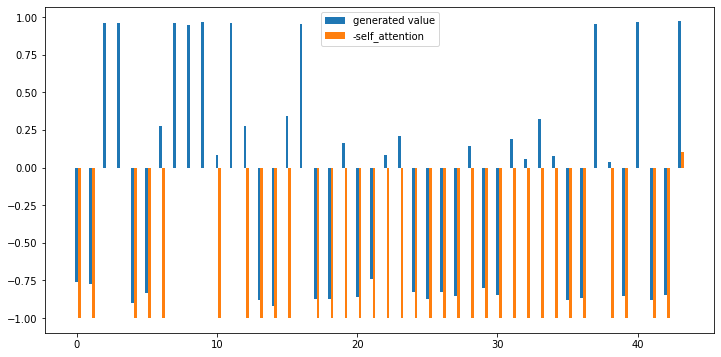

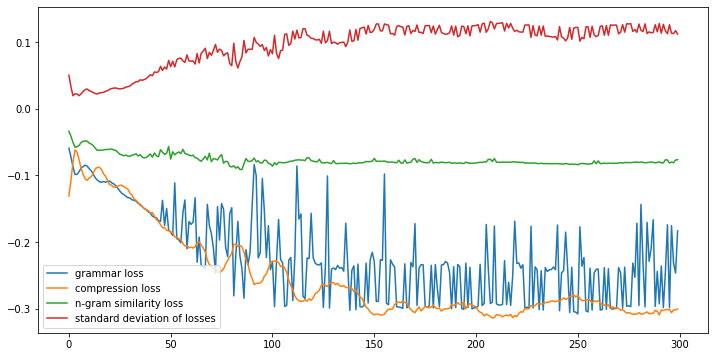

g 2.7146 	s -0.0556 	c 0.4778, score 1.3746, [피해가 큰 민감 계층에게 나쁨 단계부터 미세먼지 예보를 문자로 예·경보제가 주목을 찾아가는 역시 호평 300회 강좌는 10인 이상 신청 위해성과 고농도 발생시 알려준다.]
g -1.9727 	s -0.0533 	c 0.5000, score 0.6180, [피해가 큰 민감 계층에게 나쁨 단계부터 미세먼지 예보를 문자로 예·경보제가 주목을 찾아가는 역시 호평 300회 강좌는 이상 신청 위해성과 고농도 발생시 알려준다.]
요약률 0.4778 유사성 -0.0556 문법성 2.7146 요약 [피해가 큰 민감 계층에게 나쁨 단계부터 미세먼지 예보를 문자로 예·경보제가 주목을 찾아가는 역시 호평 300회 강좌는 10인 이상 신청 위해성과 고농도 발생시 알려준다.]


(('피해가 큰 민감 계층에게 나쁨 단계부터 미세먼지 예보를 문자로 예·경보제가 주목을 찾아가는 역시 호평 300회 강좌는 10인 이상 신청 위해성과 고농도 발생시 알려준다.',
  '피해가 큰 민감 계층에게 나쁨 단계부터 미세먼지 예보를 문자로 알려주는 예 경보제가 주목을 받았으며, 찾아가는 예보서비스 역시 호평 받았으며 300회 강좌는 10인 이상 단체 신청 시 위해성과 고농도 미세먼지 발생시 경보를 문자로 알려준다.'),
 1.3745742712583806,
 2.7145745754241943)

In [85]:
logout = True
atten_rate = 0.2
similarity = 1.0
std_factor = 3.0
txt = """
특히 미세먼지 피해가 큰 어린이·노인 등 민감 계층에게 나쁨 단계부터 미세먼지 예보를 문자로 알리는 맞춤형 예·경보제가 주목을 받고 있다. 찾아가는 미세먼지 시민강좌 역시 호평 속에 운영 중이다. 연간 300회 실시되는 이 강좌는 10인 이상 신청 단체에게 미세먼지 위해성과 고농도 미세먼지 발생시 행동요령 등을 알려준다.
"""
#The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in Italy last month. Symptoms of hepatitis A include fever, tiredness, loss of appetite, nausea and abdominal discomfort. Fargo Catholic Diocese in North Dakota (pictured) is where the bishop is located.
#The judge agreed with police that he would have been over the limit at the time his red Citroen hit Miss Titley’s blue Daihatsu Cuore on a road near Yarmouth, Isle of Wight, on October 11, 2013. His phone records showed he was also texting around the time of the crash.

sam_wgan4(get_prepared_doc(sentences_dataset[0]),txt,epochs=300,batch_size=8,display= True,retry = False,comp_rate= 1.5)

# 측정 도구...

# 한국어 rouge score...

In [48]:
!pip install rouge-score

In [49]:
import re
import six

from nltk.stem import porter
import six
from six.moves import map
from six.moves import range
from rouge_score import scoring
#from rouge_score import tokenize

def tokenize(text, stemmer):
  """Tokenize input text into a list of tokens.

  This approach aims to replicate the approach taken by Chin-Yew Lin in
  the original ROUGE implementation.

  Args:
    text: A text blob to tokenize.
    stemmer: An optional stemmer.

  Returns:
    A list of string tokens extracted from input text.
  """

  # Convert everything to lowercase.
  text = text.lower()
  # Replace any non-alpha-numeric characters with spaces.
  text =  six.ensure_str(text) #re.sub(r"[^a-z0-9]+", " ", six.ensure_str(text))

  tokens = re.split(r"\s+", text)
  if stemmer:
    # Only stem words more than 3 characters long.
    tokens = [stemmer.stem(x) if len(x) > 3 else x for x in tokens]

  # One final check to drop any empty or invalid tokens.
  #tokens = [x for x in tokens if re.match(r"^[a-z0-9]+$", six.ensure_str(x))]

  return tokens

class RougeScorer(scoring.BaseScorer):
  """Calculate rouges scores between two blobs of text.

  Sample usage:
    scorer = RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = scorer.score('The quick brown fox jumps over the lazy dog',
                          'The quick brown dog jumps on the log.')
  """

  def __init__(self, rouge_types, use_stemmer=False):
    """Initializes a new RougeScorer.

    Valid rouge types that can be computed are:
      rougen (e.g. rouge1, rouge2): n-gram based scoring.
      rougeL: Longest common subsequence based scoring.

    Args:
      rouge_types: A list of rouge types to calculate.
      use_stemmer: Bool indicating whether Porter stemmer should be used to
        strip word suffixes to improve matching.
    Returns:
      A dict mapping rouge types to Score tuples.
    """

    self.rouge_types = rouge_types
    self._stemmer = porter.PorterStemmer() if use_stemmer else None

  def score(self, target, prediction):
    """Calculates rouge scores between the target and prediction.

    Args:
      target: Text containing the target (ground truth) text.
      prediction: Text containing the predicted text.
    Returns:
      A dict mapping each rouge type to a Score object.
    Raises:
      ValueError: If an invalid rouge type is encountered.
    """

    target_tokens = tokenize(target, self._stemmer)
    prediction_tokens = tokenize(prediction, self._stemmer)
    result = {}

    for rouge_type in self.rouge_types:
      if rouge_type == "rougeL":
        # Rouge from longest common subsequences.
        scores = _score_lcs(target_tokens, prediction_tokens)
      elif rouge_type == "rougeLsum":
        # Note: Does not support multi-line text.
        def get_sents(text):
          # Assume sentences are separated by newline.
          sents = six.ensure_str(text).split("\n")
          sents = [x for x in sents if len(x)]
          return sents

        target_tokens_list = [
            tokenize(s, self._stemmer) for s in get_sents(target)]
        prediction_tokens_list = [
            tokenize(s, self._stemmer) for s in get_sents(prediction)]
        scores = _summary_level_lcs(target_tokens_list,
                                    prediction_tokens_list)
      elif re.match(r"rouge[0-9]$", six.ensure_str(rouge_type)):
        # Rouge from n-grams.
        n = int(rouge_type[5:])
        if n <= 0:
          raise ValueError("rougen requires positive n: %s" % rouge_type)
        target_ngrams = _create_ngrams(target_tokens, n)
        prediction_ngrams = _create_ngrams(prediction_tokens, n)
        scores = _score_ngrams(target_ngrams, prediction_ngrams)
      else:
        raise ValueError("Invalid rouge type: %s" % rouge_type)
      result[rouge_type] = scores

    return result


def _create_ngrams(tokens, n):
  """Creates ngrams from the given list of tokens.

  Args:
    tokens: A list of tokens from which ngrams are created.
    n: Number of tokens to use, e.g. 2 for bigrams.
  Returns:
    A dictionary mapping each bigram to the number of occurrences.
  """

  ngrams = Counter()
  for ngram in (tuple(tokens[i:i + n]) for i in range(len(tokens) - n + 1)):
    ngrams[ngram] += 1
  return ngrams


def _score_lcs(target_tokens, prediction_tokens):
  """Computes LCS (Longest Common Subsequence) rouge scores.

  Args:
    target_tokens: Tokens from the target text.
    prediction_tokens: Tokens from the predicted text.
  Returns:
    A Score object containing computed scores.
  """

  if not target_tokens or not prediction_tokens:
    return scoring.Score(precision=0, recall=0, fmeasure=0)

  # Compute length of LCS from the bottom up in a table (DP appproach).
  lcs_table = _lcs_table(target_tokens, prediction_tokens)
  lcs_length = lcs_table[-1][-1]

  precision = lcs_length / len(prediction_tokens)
  recall = lcs_length / len(target_tokens)
  fmeasure = scoring.fmeasure(precision, recall)

  return scoring.Score(precision=precision, recall=recall, fmeasure=fmeasure)


def _lcs_table(ref, can):
  """Create 2-d LCS score table."""
  rows = len(ref)
  cols = len(can)
  lcs_table = [[0] * (cols + 1) for _ in range(rows + 1)]
  for i in range(1, rows + 1):
    for j in range(1, cols + 1):
      if ref[i - 1] == can[j - 1]:
        lcs_table[i][j] = lcs_table[i - 1][j - 1] + 1
      else:
        lcs_table[i][j] = max(lcs_table[i - 1][j], lcs_table[i][j - 1])
  return lcs_table


def _backtrack_norec(t, ref, can):
  """Read out LCS."""
  i = len(ref)
  j = len(can)
  lcs = []
  while i > 0 and j > 0:
    if ref[i - 1] == can[j - 1]:
      lcs.insert(0, i-1)
      i -= 1
      j -= 1
    elif t[i][j - 1] > t[i - 1][j]:
      j -= 1
    else:
      i -= 1
  return lcs


def _summary_level_lcs(ref_sent, can_sent):
  """ROUGE: Summary-level LCS, section 3.2 in ROUGE paper.

  Args:
    ref_sent: list of tokenized reference sentences
    can_sent: list of tokenized candidate sentences

  Returns:
    summary level ROUGE score
  """
  if not ref_sent or not can_sent:
    return scoring.Score(precision=0, recall=0, fmeasure=0)

  m = sum(map(len, ref_sent))
  n = sum(map(len, can_sent))
  if not n or not m:
    return scoring.Score(precision=0, recall=0, fmeasure=0)

  # get token counts to prevent double counting
  token_cnts_r = collections.Counter()
  token_cnts_c = collections.Counter()
  for s in ref_sent:
    # s is a list of tokens
    token_cnts_r.update(s)
  for s in can_sent:
    token_cnts_c.update(s)

  hits = 0
  for r in ref_sent:
    lcs = _union_lcs(r, can_sent)
    # Prevent double-counting:
    # The paper describes just computing hits += len(_union_lcs()),
    # but the implementation prevents double counting. We also
    # implement this as in version 1.5.5.
    for t in lcs:
      if token_cnts_c[t] > 0 and token_cnts_r[t] > 0:
        hits += 1
        token_cnts_c[t] -= 1
        token_cnts_r[t] -= 1

  recall = hits / m
  precision = hits / n
  fmeasure = scoring.fmeasure(precision, recall)
  return scoring.Score(precision=precision, recall=recall, fmeasure=fmeasure)


def _union_lcs(ref, c_list):
  """Find union LCS between a ref sentence and list of candidate sentences.

  Args:
    ref: list of tokens
    c_list: list of list of indices for LCS into reference summary

  Returns:
    List of tokens in ref representing union LCS.
  """
  lcs_list = [lcs_ind(ref, c) for c in c_list]
  return [ref[i] for i in _find_union(lcs_list)]


def _find_union(lcs_list):
  """Finds union LCS given a list of LCS."""
  return sorted(list(set().union(*lcs_list)))


def lcs_ind(ref, can):
  """Returns one of the longest lcs."""
  t = _lcs_table(ref, can)
  return _backtrack_norec(t, ref, can)


def _score_ngrams(target_ngrams, prediction_ngrams):
  """Compute n-gram based rouge scores.

  Args:
    target_ngrams: A Counter object mapping each ngram to number of
      occurrences for the target text.
    prediction_ngrams: A Counter object mapping each ngram to number of
      occurrences for the prediction text.
  Returns:
    A Score object containing computed scores.
  """

  intersection_ngrams_count = 0
  for ngram in six.iterkeys(target_ngrams):
    intersection_ngrams_count += min(target_ngrams[ngram],
                                     prediction_ngrams[ngram])
  target_ngrams_count = sum(target_ngrams.values())
  prediction_ngrams_count = sum(prediction_ngrams.values())

  precision = intersection_ngrams_count / max(prediction_ngrams_count, 1)
  recall = intersection_ngrams_count / max(target_ngrams_count, 1)
  fmeasure = scoring.fmeasure(precision, recall)

  return scoring.Score(precision=precision, recall=recall, fmeasure=fmeasure)  

In [50]:

scorer = RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)

# 종합 Test

In [51]:
@@@

SyntaxError: ignored

In [89]:
import io

result_data = {}

result_data['ID'] = []
result_data['Original'] = []
result_data['Step0'] = []
result_data['Step1'] = []
result_data['Step2'] = []
result_data['Step3'] = []
result_data['Ground Truth'] = []

result_data['S0.R1'] = []
result_data['S0.R2'] = []
result_data['S0.RL'] = []
result_data['S0.Similarity'] = []
result_data['S0.Grammar'] = []

result_data['S1.R1'] = []
result_data['S1.R2'] = []
result_data['S1.RL'] = []
result_data['S1.Similarity'] = []
result_data['S1.Grammar'] = []

result_data['S2.R1'] = []
result_data['S2.R2'] = []
result_data['S2.RL'] = []
result_data['S2.Similarity'] = []
result_data['S2.Grammar'] = []

result_data['S3.R1'] = []
result_data['S3.R2'] = []
result_data['S3.RL'] = []
result_data['S3.Similarity'] = []
result_data['S3.Grammar'] = []

statistics_columns = ['S0.R1','S0.R2','S0.RL','S0.Similarity','S0.Grammar','S1.R1','S1.R2','S1.RL','S1.Similarity','S1.Grammar','S2.R1','S2.R2','S2.RL','S2.Similarity','S2.Grammar','S3.R1','S3.R2','S3.RL','S3.Similarity','S3.Grammar']

atten_rate = 0.2
similarity = 1.0
std_factor = 3.0

#es = ExtactiveSummarizer()
cnt = 0
pd.set_option('display.max_columns', 100)

logout = False
for rate in range(0,1):
    comp_rate=1.5
    #result_data['comp_rate'].append(comp_rate)
    for try_count in range(1000):
        
        full_text = get_prepared_doc(sentences_dataset[try_count])
        '''
        try:
            del model
            print('delete model')
        except Exception as ex:
            pass
        model = EncoderDecoderModel.from_pretrained("/content/drive/MyDrive/GAN_ENDE/en_sentence_complete_model")
        '''
        try:
            step0 = es.generate_summary(full_text,top_n=3,min_length=0)[0]  
            #org_text = besm(full_text,num_sentences=9)
            step1 = es.generate_summary(full_text,top_n=6,min_length=0)[0]          
            org_sentences = np.array(nltk.sent_tokenize(step1.strip()))
            if logout:
                print('BESM Summary sentance length:',len(org_sentences))
            (step2,step3),grammar,simil = summary(full_text,step1,steps=2,top_rank=2,comp_rate=comp_rate)
            '''
            tmp = []
            for txt in np.array(nltk.sent_tokenize(step2.strip())):
                tmp.append(sentence_correct(txt))         
            step3 = ' '.join(tmp)
            '''

            ground_trouth = gold_summary[try_count]
            
            print('='*50 + ' Original Document ' + str(try_count) + '='*50)
            for txt in np.array(nltk.sent_tokenize(full_text)):
                print(txt)
            print('-'*50 + ' Step0 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step0.strip())):
                print(txt)                       
            print('-'*50 + ' Step1 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step1.strip())):
                print(txt)                
            print('-'*50 + ' Step2 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step2.strip())):
                print(txt)
            print('-'*50 + ' Step3 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step3.strip())):
                print(txt)                
            print('-'*50 + ' Ground truth' + '-'*50)
            print(ground_trouth)
            print('-'*120)

            #with io.open('/content/drive/MyDrive/GAN_ENDE/CNN_Daily_summary_result.txt','a',encoding='utf8') as f:
            #    f.write(org_text + '\r\n\r\n')
            s0_rouge = scorer.score(ground_trouth,step0)            
            s1_rouge = scorer.score(ground_trouth,step1)
            s2_rouge = scorer.score(ground_trouth,step2)
            s3_rouge = scorer.score(ground_trouth,step3)
            s0_simil = similarity3(full_text,step0)
            s1_simil = similarity3(full_text,step1)
            s2_simil = similarity3(full_text,step2)
            s3_simil = similarity3(full_text,step3)
            s0_gramm = grammar3(full_text,step0)
            s1_gramm = grammar3(full_text,step1)
            s2_gramm = grammar3(full_text,step2) 
            s3_gramm = grammar3(full_text,step3)  
            #print(scores['rouge1'].fmeasure)
            #if s2_rouge['rouge1'].fmeasure > 0.1:

            result_data['ID'].append('CNN/DM-'+str(try_count))
            result_data['Original'].append(full_text)
            result_data['Step0'].append(step0)            
            result_data['Step1'].append(step1)
            result_data['Step2'].append(step2)
            result_data['Step3'].append(step3)
            result_data['Ground Truth'].append(ground_trouth)

            result_data['S0.R1'].append(s0_rouge['rouge1'].fmeasure)
            result_data['S0.R2'].append(s0_rouge['rouge2'].fmeasure)
            result_data['S0.RL'].append(s0_rouge['rougeL'].fmeasure)
            result_data['S0.Similarity'].append(s0_simil)
            result_data['S0.Grammar'].append(s0_gramm)

            result_data['S1.R1'].append(s1_rouge['rouge1'].fmeasure)
            result_data['S1.R2'].append(s1_rouge['rouge2'].fmeasure)
            result_data['S1.RL'].append(s1_rouge['rougeL'].fmeasure)
            result_data['S1.Similarity'].append(s1_simil)
            result_data['S1.Grammar'].append(s1_gramm)

            result_data['S2.R1'].append(s2_rouge['rouge1'].fmeasure)
            result_data['S2.R2'].append(s2_rouge['rouge2'].fmeasure)
            result_data['S2.RL'].append(s2_rouge['rougeL'].fmeasure)
            result_data['S2.Similarity'].append(s2_simil)
            result_data['S2.Grammar'].append(s2_gramm)

            result_data['S3.R1'].append(s3_rouge['rouge1'].fmeasure)
            result_data['S3.R2'].append(s3_rouge['rouge2'].fmeasure)
            result_data['S3.RL'].append(s3_rouge['rougeL'].fmeasure)
            result_data['S3.Similarity'].append(s3_simil)
            result_data['S3.Grammar'].append(s3_gramm)

            print()
            df_result_data = pd.DataFrame(result_data)
            print(df_result_data[statistics_columns].iloc[-1])
            print()
            df_mean = df_result_data[statistics_columns].mean()
            print('** Mean result **')
            print(df_mean)
            del df_mean
            del df_result_data

            cnt+=1
            if cnt > 100:
                break

        except Exception as ex:
            print(ex)

print('** Total mean result **')
df_result_data = pd.DataFrame(result_data)
df_mean = df_result_data[statistics_columns].mean()
print(df_mean)
df_result_data.to_pickle("/content/drive/MyDrive/GAN_ENDE/df_result_93.pkl")

df_result_data[['ID']+statistics_columns]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
엔넷트러스트는 망분리 환경에서 관리자가 수동으로 진행하는 패치나 업데이트 관리업무를 망분리 환경의 에어갭(Air-Gap)을 유지한다.
무결성을 확인하고 패치·업데이트 필요 시 온라인으로 스위칭해 안전하게 정보를 수집·전달하고 다시 스위칭해 오프라인을 유지하는 자동 패치·업데이트 전달솔루션이다.
김일용 앤앤에스피 대표는 "폭발적 경제성장을 하고 있는 베트남 시장에서 에너지 등 기반시설 확대에 요구되는 산업보안수요에 선제 대응하는 전기를 마련했다"면서 "부스를 방문한 바이어 정보를 바탕으로 동남아 시장진출 전략을 가다듬어 한 단계 도약하겠다"고 말했다.
-------------------------------------------------- Step0 100--------------------------------------------------
엔넷트러스트는 망분리 환경에서 관리자가 수동으로 진행하는 패치나 업데이트 관리업무를 망분리 환경의 에어갭(Air-Gap)을 유지한다.
무결성을 확인하고 패치·업데이트 필요 시 온라인으로 스위칭해 안전하게 정보를 수집·전달하고 다시 스위칭해 오프라인을 유지하는 자동 패치·업데이트 전달솔루션이다.
김일용 앤앤에스피 대표는 "폭발적 경제성장을 하고 있는 베트남 시장에서 에너지 등 기반시설 확대에 요구되는 산업보안수요에 선제 대응하는 전기를 마련했다"면서 "부스를 방문한 바이어 정보를 바탕으로 동남아 시장진출 전략을 가다듬어 한 단계 도약하겠다"고 말했다.
-------------------------------------------------- Step1 100--------------------------------------------------
앤앤에스피는 국내 최다 레퍼런스를 보유한 물리적 일방향 전송장비 '앤넷다이오드(nNetDiode)'를 출품했다.
다양한 국가 주요기반시설보호 구축 사례와 더불어 5대 발전기관 납품 실적과 제품 홍보영상 등을 전시, 

,ID,S0.R1,S0.R2,S0.RL,S0.Similarity,S0.Grammar,S1.R1,S1.R2,S1.RL,S1.Similarity,S1.Grammar,S2.R1,S2.R2,S2.RL,S2.Similarity,S2.Grammar,S3.R1,S3.R2,S3.RL,S3.Similarity,S3.Grammar
0,CNN/DM-0,0.053333,0.000000,0.053333,0.901448,0.999943,0.050420,0.000000,0.050420,0.933023,0.999929,0.027778,0.000000,0.027778,0.884910,0.999861,0.066667,0.000000,0.066667,0.890084,0.999944
1,CNN/DM-8,0.075472,0.000000,0.056604,0.951998,0.999944,0.193548,0.104575,0.180645,1.000000,0.999945,0.153846,0.044944,0.131868,0.938413,0.999756,0.252252,0.165138,0.234234,0.895565,0.999945
2,CNN/DM-9,0.168421,0.021505,0.084211,0.933524,0.999941,0.166667,0.030769,0.060606,0.950859,0.999940,0.117647,0.024096,0.047059,0.921851,0.999793,0.099010,0.020202,0.039604,0.926914,0.999944
3,CNN/DM-11,0.100000,0.020408,0.060000,0.924324,0.999942,0.072539,0.020942,0.051813,0.954879,0.999943,0.088496,0.018018,0.070796,0.924982,0.999606,0.119658,0.052174,0.085470,0.926487,0.999945
4,CNN/DM-13,0.085106,0.000000,0.063830,0.830008,0.999946,0.133333,0.030075,0.074074,0.896355,0.999917,0.137931,0.023529,0.091954,0.826891,0.999937,0.134615,0.019608,0.076923,0.833853,0.999943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,CNN/DM-230,0.036036,0.000000,0.036036,0.789463,0.999907,0.065421,0.009434,0.037383,0.927205,0.999910,0.060150,0.000000,0.030075,0.820505,0.999776,0.064935,0.000000,0.025974,0.805418,0.999941
97,CNN/DM-231,0.108696,0.000000,0.086957,0.915258,0.999945,0.100719,0.000000,0.057554,0.948801,0.999945,0.087912,0.000000,0.065934,0.901802,0.999920,0.074074,0.000000,0.055556,0.903230,0.999946
98,CNN/DM-232,0.148148,0.050633,0.098765,0.916965,0.999877,0.161290,0.081967,0.145161,0.947367,0.999918,0.109589,0.000000,0.082192,0.885813,0.999385,0.131868,0.022472,0.109890,0.894839,0.999944
99,CNN/DM-235,0.202532,0.129870,0.177215,0.886110,0.999945,0.210526,0.137405,0.195489,0.988472,0.999946,0.243902,0.075000,0.219512,0.853604,0.999831,0.183486,0.056075,0.183486,0.838807,0.999943


In [ ]:
txt = """
신촌세브란스, 여의도성모병원 등 15개 대형 병원.
및 지역대학병원들이 캐나다, 호주, 뉴질랜드 등
"""

txt.replace('\n',' ').split(' ')

In [90]:
import io

result_data = {}

result_data['ID'] = []
result_data['Original'] = []
result_data['Step0'] = []
result_data['Step1'] = []
result_data['Step2'] = []
result_data['Step3'] = []
result_data['Ground Truth'] = []

result_data['S0.R1'] = []
result_data['S0.R2'] = []
result_data['S0.RL'] = []
result_data['S0.Similarity'] = []
result_data['S0.Grammar'] = []

result_data['S1.R1'] = []
result_data['S1.R2'] = []
result_data['S1.RL'] = []
result_data['S1.Similarity'] = []
result_data['S1.Grammar'] = []

result_data['S2.R1'] = []
result_data['S2.R2'] = []
result_data['S2.RL'] = []
result_data['S2.Similarity'] = []
result_data['S2.Grammar'] = []

result_data['S3.R1'] = []
result_data['S3.R2'] = []
result_data['S3.RL'] = []
result_data['S3.Similarity'] = []
result_data['S3.Grammar'] = []

statistics_columns = ['S0.R1','S0.R2','S0.RL','S0.Similarity','S0.Grammar','S1.R1','S1.R2','S1.RL','S1.Similarity','S1.Grammar','S2.R1','S2.R2','S2.RL','S2.Similarity','S2.Grammar','S3.R1','S3.R2','S3.RL','S3.Similarity','S3.Grammar']

atten_rate = 0.2
similarity = 1.0
std_factor = 3.0

#es = ExtactiveSummarizer()
cnt = 0
pd.set_option('display.max_columns', 100)

logout = False
for rate in range(0,1):
    comp_rate=1.5
    #result_data['comp_rate'].append(comp_rate)
    for try_count in range(1000):
        
        full_text = get_prepared_doc(sentences_dataset[try_count])
        '''
        try:
            del model
            print('delete model')
        except Exception as ex:
            pass
        model = EncoderDecoderModel.from_pretrained("/content/drive/MyDrive/GAN_ENDE/en_sentence_complete_model")
        '''
        try:
            step0 = es.generate_summary(full_text,top_n=1,min_length=0)[0]  
            #org_text = besm(full_text,num_sentences=9)
            step1 = es.generate_summary(full_text,top_n=3,min_length=0)[0]          
            org_sentences = np.array(nltk.sent_tokenize(step1.strip()))
            if logout:
                print('BESM Summary sentance length:',len(org_sentences))
            (step2,step3),grammar,simil = summary(full_text,step1,steps=3,top_rank=3,comp_rate=comp_rate)
            '''
            tmp = []
            for txt in np.array(nltk.sent_tokenize(step2.strip())):
                tmp.append(sentence_correct(txt))         
            step3 = ' '.join(tmp)
            '''

            ground_trouth = gold_summary[try_count]
            
            print('='*50 + ' Original Document ' + str(try_count) + '='*50)
            for txt in np.array(nltk.sent_tokenize(full_text)):
                print(txt)
            print('-'*50 + ' Step0 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step0.strip())):
                print(txt)                       
            print('-'*50 + ' Step1 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step1.strip())):
                print(txt)                
            print('-'*50 + ' Step2 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step2.strip())):
                print(txt)
            print('-'*50 + ' Step3 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step3.strip())):
                print(txt)                
            print('-'*50 + ' Ground truth' + '-'*50)
            print(ground_trouth)
            print('-'*120)

            #with io.open('/content/drive/MyDrive/GAN_ENDE/CNN_Daily_summary_result.txt','a',encoding='utf8') as f:
            #    f.write(org_text + '\r\n\r\n')
            s0_rouge = scorer.score(ground_trouth,step0)            
            s1_rouge = scorer.score(ground_trouth,step1)
            s2_rouge = scorer.score(ground_trouth,step2)
            s3_rouge = scorer.score(ground_trouth,step3)
            s0_simil = similarity3(full_text,step0)
            s1_simil = similarity3(full_text,step1)
            s2_simil = similarity3(full_text,step2)
            s3_simil = similarity3(full_text,step3)
            s0_gramm = grammar3(full_text,step0)
            s1_gramm = grammar3(full_text,step1)
            s2_gramm = grammar3(full_text,step2) 
            s3_gramm = grammar3(full_text,step3)  
            #print(scores['rouge1'].fmeasure)
            #if s2_rouge['rouge1'].fmeasure > 0.1:

            result_data['ID'].append('CNN/DM-'+str(try_count))
            result_data['Original'].append(full_text)
            result_data['Step0'].append(step0)            
            result_data['Step1'].append(step1)
            result_data['Step2'].append(step2)
            result_data['Step3'].append(step3)
            result_data['Ground Truth'].append(ground_trouth)

            result_data['S0.R1'].append(s0_rouge['rouge1'].fmeasure)
            result_data['S0.R2'].append(s0_rouge['rouge2'].fmeasure)
            result_data['S0.RL'].append(s0_rouge['rougeL'].fmeasure)
            result_data['S0.Similarity'].append(s0_simil)
            result_data['S0.Grammar'].append(s0_gramm)

            result_data['S1.R1'].append(s1_rouge['rouge1'].fmeasure)
            result_data['S1.R2'].append(s1_rouge['rouge2'].fmeasure)
            result_data['S1.RL'].append(s1_rouge['rougeL'].fmeasure)
            result_data['S1.Similarity'].append(s1_simil)
            result_data['S1.Grammar'].append(s1_gramm)

            result_data['S2.R1'].append(s2_rouge['rouge1'].fmeasure)
            result_data['S2.R2'].append(s2_rouge['rouge2'].fmeasure)
            result_data['S2.RL'].append(s2_rouge['rougeL'].fmeasure)
            result_data['S2.Similarity'].append(s2_simil)
            result_data['S2.Grammar'].append(s2_gramm)

            result_data['S3.R1'].append(s3_rouge['rouge1'].fmeasure)
            result_data['S3.R2'].append(s3_rouge['rouge2'].fmeasure)
            result_data['S3.RL'].append(s3_rouge['rougeL'].fmeasure)
            result_data['S3.Similarity'].append(s3_simil)
            result_data['S3.Grammar'].append(s3_gramm)

            print()
            df_result_data = pd.DataFrame(result_data)
            print(df_result_data[statistics_columns].iloc[-1])
            print()
            df_mean = df_result_data[statistics_columns].mean()
            print('** Mean result **')
            print(df_mean)
            del df_mean
            del df_result_data

            cnt+=1
            if cnt > 100:
                break

        except Exception as ex:
            print(ex)

print('** Total mean result **')
df_result_data = pd.DataFrame(result_data)
df_mean = df_result_data[statistics_columns].mean()
print(df_mean)
df_result_data.to_pickle("/content/drive/MyDrive/GAN_ENDE/df_result_93.pkl")

df_result_data[['ID']+statistics_columns]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
카카오IX 관계자는 "내년 영국 정규 오프라인 스토어 개점도 계획 중으로, 현지 고객과의 접점이 더욱 강화될 것으로 기대된다"고 말했다.
-------------------------------------------------- Step0 46--------------------------------------------------
카카오IX 관계자는 "내년 영국 정규 오프라인 스토어 개점도 계획 중으로, 현지 고객과의 접점이 더욱 강화될 것으로 기대된다"고 말했다.
-------------------------------------------------- Step1 46--------------------------------------------------
이와 더불어 기존에 영국에서 인기가 많았던 바디ㆍ베이비 필로우, 페이스 미니 손거울, 피규어 키링을 비롯해, 겨울에 활용도가 높은 홈리빙 굿즈 '라이언 인 더 포레스트' 슬리퍼와 머그잔, 폼폼프렌즈 소프트 인형, 수면양말 등의 아이템도 함께 판매될 예정이다.
팝업스토어 운영기간은 축제가 종료되는 1월 5일까지다.
카카오IX 관계자는 "내년 영국 정규 오프라인 스토어 개점도 계획 중으로, 현지 고객과의 접점이 더욱 강화될 것으로 기대된다"고 말했다.
-------------------------------------------------- Step2 46--------------------------------------------------
이와 더불어 영국에서 많았던 필로우 미니 손거울 키링을 비롯해 활용도가 높은 굿즈 라이언 인 더 폼폼프렌즈 인형 수면양말 운영기간은 축제가 종료되는 1월 카카오IX 관계자는 오프라인 스토어 더욱 말했다.
-------------------------------------------------- Step3 46--------------------------------------------------
이와 

,ID,S0.R1,S0.R2,S0.RL,S0.Similarity,S0.Grammar,S1.R1,S1.R2,S1.RL,S1.Similarity,S1.Grammar,S2.R1,S2.R2,S2.RL,S2.Similarity,S2.Grammar,S3.R1,S3.R2,S3.RL,S3.Similarity,S3.Grammar
0,CNN/DM-0,0.000000,0.000000,0.000000,0.866396,0.999945,0.053333,0.000000,0.053333,0.901448,0.999943,0.078431,0.000000,0.078431,0.874345,0.999943,0.098361,0.000000,0.065574,0.870023,0.999941
1,CNN/DM-3,0.000000,0.000000,0.000000,0.898821,0.999946,0.024691,0.000000,0.024691,0.917508,0.999922,0.030303,0.000000,0.030303,0.809084,0.998302,0.054054,0.000000,0.027027,0.806475,0.999943
2,CNN/DM-5,0.000000,0.000000,0.000000,0.857441,0.999942,0.000000,0.000000,0.000000,0.914846,0.999944,0.000000,0.000000,0.000000,0.756199,0.999934,0.000000,0.000000,0.000000,0.779368,0.999946
3,CNN/DM-6,0.046512,0.000000,0.046512,0.805363,0.985224,0.157895,0.027027,0.131579,0.900561,0.999651,0.163934,0.033898,0.131148,0.863799,0.999943,0.142857,0.029412,0.114286,0.866570,0.999942
4,CNN/DM-7,0.033898,0.000000,0.033898,0.784486,0.999944,0.041667,0.000000,0.020833,0.819568,0.999945,0.031250,0.000000,0.031250,0.754250,0.999722,0.029851,0.000000,0.029851,0.733763,0.999945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,CNN/DM-142,0.048780,0.000000,0.048780,0.809557,0.999944,0.125000,0.032258,0.093750,0.859109,0.999926,0.093023,0.000000,0.046512,0.808585,0.999928,0.078431,0.000000,0.078431,0.833102,0.999946
97,CNN/DM-143,0.000000,0.000000,0.000000,0.819625,0.999938,0.074074,0.025316,0.074074,0.873483,0.999941,0.038462,0.000000,0.038462,0.853652,0.999867,0.035088,0.000000,0.035088,0.855052,0.999940
98,CNN/DM-144,0.260870,0.227273,0.260870,0.916255,0.999947,0.160920,0.117647,0.160920,0.930584,0.999941,0.123077,0.031746,0.123077,0.816918,0.999880,0.135135,0.111111,0.135135,0.826896,0.999945
99,CNN/DM-145,0.000000,0.000000,0.000000,0.832886,0.962948,0.042553,0.000000,0.042553,0.911540,0.999506,0.062500,0.000000,0.062500,0.854543,0.999920,0.054795,0.000000,0.054795,0.862173,0.999945


In [91]:
import io

result_data = {}

result_data['ID'] = []
result_data['Original'] = []
result_data['Step0'] = []
result_data['Step1'] = []
result_data['Step2'] = []
result_data['Step3'] = []
result_data['Ground Truth'] = []

result_data['S0.R1'] = []
result_data['S0.R2'] = []
result_data['S0.RL'] = []
result_data['S0.Similarity'] = []
result_data['S0.Grammar'] = []

result_data['S1.R1'] = []
result_data['S1.R2'] = []
result_data['S1.RL'] = []
result_data['S1.Similarity'] = []
result_data['S1.Grammar'] = []

result_data['S2.R1'] = []
result_data['S2.R2'] = []
result_data['S2.RL'] = []
result_data['S2.Similarity'] = []
result_data['S2.Grammar'] = []

result_data['S3.R1'] = []
result_data['S3.R2'] = []
result_data['S3.RL'] = []
result_data['S3.Similarity'] = []
result_data['S3.Grammar'] = []

statistics_columns = ['S0.R1','S0.R2','S0.RL','S0.Similarity','S0.Grammar','S1.R1','S1.R2','S1.RL','S1.Similarity','S1.Grammar','S2.R1','S2.R2','S2.RL','S2.Similarity','S2.Grammar','S3.R1','S3.R2','S3.RL','S3.Similarity','S3.Grammar']

atten_rate = 0.2
similarity = 1.0
std_factor = 3.0

#es = ExtactiveSummarizer()
cnt = 0
pd.set_option('display.max_columns', 100)

logout = False
for rate in range(0,1):
    comp_rate=1.5
    #result_data['comp_rate'].append(comp_rate)
    for try_count in range(1000):
        
        full_text = get_prepared_doc(sentences_dataset[try_count])
        '''
        try:
            del model
            print('delete model')
        except Exception as ex:
            pass
        model = EncoderDecoderModel.from_pretrained("/content/drive/MyDrive/GAN_ENDE/en_sentence_complete_model")
        '''
        try:
            step0 = es.generate_summary(full_text,top_n=1,min_length=0)[0]  
            #org_text = besm(full_text,num_sentences=9)
            step1 = es.generate_summary(full_text,top_n=2,min_length=0)[0]          
            org_sentences = np.array(nltk.sent_tokenize(step1.strip()))
            if logout:
                print('BESM Summary sentance length:',len(org_sentences))
            (step2,step3),grammar,simil = summary(full_text,step1,steps=2,top_rank=2,comp_rate=comp_rate)
            '''
            tmp = []
            for txt in np.array(nltk.sent_tokenize(step2.strip())):
                tmp.append(sentence_correct(txt))         
            step3 = ' '.join(tmp)
            '''

            ground_trouth = gold_summary[try_count]
            
            print('='*50 + ' Original Document ' + str(try_count) + '='*50)
            for txt in np.array(nltk.sent_tokenize(full_text)):
                print(txt)
            print('-'*50 + ' Step0 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step0.strip())):
                print(txt)                       
            print('-'*50 + ' Step1 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step1.strip())):
                print(txt)                
            print('-'*50 + ' Step2 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step2.strip())):
                print(txt)
            print('-'*50 + ' Step3 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step3.strip())):
                print(txt)                
            print('-'*50 + ' Ground truth' + '-'*50)
            print(ground_trouth)
            print('-'*120)

            #with io.open('/content/drive/MyDrive/GAN_ENDE/CNN_Daily_summary_result.txt','a',encoding='utf8') as f:
            #    f.write(org_text + '\r\n\r\n')
            s0_rouge = scorer.score(ground_trouth,step0)            
            s1_rouge = scorer.score(ground_trouth,step1)
            s2_rouge = scorer.score(ground_trouth,step2)
            s3_rouge = scorer.score(ground_trouth,step3)
            s0_simil = similarity3(full_text,step0)
            s1_simil = similarity3(full_text,step1)
            s2_simil = similarity3(full_text,step2)
            s3_simil = similarity3(full_text,step3)
            s0_gramm = grammar3(full_text,step0)
            s1_gramm = grammar3(full_text,step1)
            s2_gramm = grammar3(full_text,step2) 
            s3_gramm = grammar3(full_text,step3)  
            #print(scores['rouge1'].fmeasure)
            #if s2_rouge['rouge1'].fmeasure > 0.1:

            result_data['ID'].append('CNN/DM-'+str(try_count))
            result_data['Original'].append(full_text)
            result_data['Step0'].append(step0)            
            result_data['Step1'].append(step1)
            result_data['Step2'].append(step2)
            result_data['Step3'].append(step3)
            result_data['Ground Truth'].append(ground_trouth)

            result_data['S0.R1'].append(s0_rouge['rouge1'].fmeasure)
            result_data['S0.R2'].append(s0_rouge['rouge2'].fmeasure)
            result_data['S0.RL'].append(s0_rouge['rougeL'].fmeasure)
            result_data['S0.Similarity'].append(s0_simil)
            result_data['S0.Grammar'].append(s0_gramm)

            result_data['S1.R1'].append(s1_rouge['rouge1'].fmeasure)
            result_data['S1.R2'].append(s1_rouge['rouge2'].fmeasure)
            result_data['S1.RL'].append(s1_rouge['rougeL'].fmeasure)
            result_data['S1.Similarity'].append(s1_simil)
            result_data['S1.Grammar'].append(s1_gramm)

            result_data['S2.R1'].append(s2_rouge['rouge1'].fmeasure)
            result_data['S2.R2'].append(s2_rouge['rouge2'].fmeasure)
            result_data['S2.RL'].append(s2_rouge['rougeL'].fmeasure)
            result_data['S2.Similarity'].append(s2_simil)
            result_data['S2.Grammar'].append(s2_gramm)

            result_data['S3.R1'].append(s3_rouge['rouge1'].fmeasure)
            result_data['S3.R2'].append(s3_rouge['rouge2'].fmeasure)
            result_data['S3.RL'].append(s3_rouge['rougeL'].fmeasure)
            result_data['S3.Similarity'].append(s3_simil)
            result_data['S3.Grammar'].append(s3_gramm)

            print()
            df_result_data = pd.DataFrame(result_data)
            print(df_result_data[statistics_columns].iloc[-1])
            print()
            df_mean = df_result_data[statistics_columns].mean()
            print('** Mean result **')
            print(df_mean)
            del df_mean
            del df_result_data

            cnt+=1
            if cnt > 100:
                break

        except Exception as ex:
            print(ex)

print('** Total mean result **')
df_result_data = pd.DataFrame(result_data)
df_mean = df_result_data[statistics_columns].mean()
print(df_mean)
df_result_data.to_pickle("/content/drive/MyDrive/GAN_ENDE/df_result_93.pkl")

df_result_data[['ID']+statistics_columns]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
S3.R2            0.000000
S3.RL            0.000000
S3.Similarity    0.831227
S3.Grammar       0.999932
Name: 30, dtype: float64

** Mean result **
S0.R1            0.072942
S0.R2            0.020546
S0.RL            0.062929
S0.Similarity    0.825215
S0.Grammar       0.988574
S1.R1            0.115995
S1.R2            0.051823
S1.RL            0.096082
S1.Similarity    0.865522
S1.Grammar       0.999750
S2.R1            0.089621
S2.R2            0.022535
S2.RL            0.078667
S2.Similarity    0.827771
S2.Grammar       0.999291
S3.R1            0.091153
S3.R2            0.026003
S3.RL            0.077795
S3.Similarity    0.818234
S3.Grammar       0.999943
dtype: float64
'NoneType' object is not iterable
================================================== Original Document 38==================================================
미분양 관리지역으로 지정돼 관리를 받아오던 경북 포항에서 분양 2년여만에 완판된 단지가 이목을 끌고 있다.
공급과잉에 이어 2016년부터 올해까지 지진, 강풍, 태풍 등 자연재해까지 겹쳐 주택시장이 극도로 얼어붙어있던 상황에

,ID,S0.R1,S0.R2,S0.RL,S0.Similarity,S0.Grammar,S1.R1,S1.R2,S1.RL,S1.Similarity,S1.Grammar,S2.R1,S2.R2,S2.RL,S2.Similarity,S2.Grammar,S3.R1,S3.R2,S3.RL,S3.Similarity,S3.Grammar
0,CNN/DM-0,0.000000,0.000000,0.000000,0.866396,0.999945,0.029851,0.000000,0.029851,0.893454,0.999946,0.000000,0.000000,0.000000,0.745798,0.999215,0.068966,0.035714,0.068966,0.733128,0.999939
1,CNN/DM-1,0.294118,0.090909,0.176471,0.711806,0.999945,0.273973,0.084507,0.164384,0.829504,0.999207,0.178571,0.037037,0.107143,0.743173,0.999909,0.229508,0.101695,0.131148,0.710408,0.999947
2,CNN/DM-2,0.352941,0.242424,0.352941,0.844369,0.999945,0.240000,0.163265,0.240000,0.854129,0.999944,0.260870,0.149254,0.260870,0.836730,0.999821,0.205128,0.078947,0.205128,0.848083,0.999941
3,CNN/DM-3,0.000000,0.000000,0.000000,0.898821,0.999946,0.029851,0.000000,0.029851,0.910365,0.999907,0.000000,0.000000,0.000000,0.906446,0.999947,0.000000,0.000000,0.000000,0.897645,0.999945
4,CNN/DM-5,0.000000,0.000000,0.000000,0.857441,0.999942,0.000000,0.000000,0.000000,0.880683,0.999944,0.000000,0.000000,0.000000,0.680276,0.997394,0.000000,0.000000,0.000000,0.690036,0.999947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,CNN/DM-120,0.000000,0.000000,0.000000,0.846476,0.997395,0.059701,0.000000,0.059701,0.901569,0.999606,0.036364,0.000000,0.036364,0.885119,0.998287,0.031746,0.000000,0.031746,0.889385,0.999944
97,CNN/DM-121,0.000000,0.000000,0.000000,0.876850,0.999944,0.027778,0.000000,0.027778,0.899652,0.999945,0.000000,0.000000,0.000000,0.857414,0.999917,0.000000,0.000000,0.000000,0.874623,0.999942
98,CNN/DM-122,0.000000,0.000000,0.000000,0.929619,0.999946,0.000000,0.000000,0.000000,0.945303,0.999941,0.000000,0.000000,0.000000,0.931867,0.999910,0.000000,0.000000,0.000000,0.941273,0.999944
99,CNN/DM-125,0.000000,0.000000,0.000000,0.855144,0.999944,0.071429,0.000000,0.023810,0.911178,0.999943,0.032787,0.000000,0.032787,0.898573,0.999901,0.027027,0.000000,0.027027,0.892075,0.999942
